# **Presentación**

## **Caracteristicas del proyecto**

### **Tecnicatura Universitaria en Inteligencia Artificial**

#### Trabajo Práctico Integrador
#### ***Aprendizaje Automatico 1***


---

**Equipo**:
- Ferrucci Constantino
- Giampaoli Fabio

<br>

**Fechas**:
- 13/10/2023 (Primer entrega. Hasta item 3)
- 27/10/2023 (Segunda entrega. Hasta item 4)
- 20/11/2023 (Tercer entrega. Hasta ítem 5 y 6)
- 7/12/2023 (Cuarta entrega. Hasta items 7, 8, 9 y 10)

---

### **Resumen**


El dataset elegido consiste de variables meteorologicas de Australia en determinado periodo de tiempo que seran de interes para la predicion y clasificacion de la cantidad y posibilidad de lluvia en algun dia con ciertas caracteristicas mediante modelos estudiados en el cursado de la materia.\
<br>

El dataset cuenta con distintos tipos de varibables (continuas, categoricas, discretas, binarias), muchas de ellas son de utilidad para obtener informacion del climatica del registro (un dia particular), y otras son de utilidad para ubicacion espacio-temporal del registro.\
<br>

Es claro que un los modelos por si solos no pueden realizar un buen trabajo si el dataset no es preprocesado para maximizar el rendimiento del entrenamiento. Por ello, la primer etapa es el tratamiento primario de los datos, donde se imputan, codifican, suavizan, y estandarizan las variables.\
<br>

Luego, es de principal interes el analisis del conjunto de datos para conocer el contexto sobre el cual vamos a desarrollarnos. Conocer las distribuciones de las variables, sus relaciones con las demas, y comportamientos explicativos para las variables objetivos.\
<br>

Por ultimo, se realizan las predicciones con los diferentes modelos y se comparan sus rendimientos utilizando metricas de validacion para comprender cual y por que un modelo hace mejor que los demas.

# **Entorno**

En este espacio se establecen las herramientas y recursos a utilizar, se cargan en el entorno para comenzar a procesar.

### Librerías

Se hace uso de distintas librerias de Python que facilitaran herramientas de procesamiento de datos, visualizacion y obtencion de modelo y metricas.

Algunas de estas librerias no han sido utilizadas durante el cursado de la materia, pero son de interes para algunas tareas.

In [ ]:
%%capture
!pip install tqdm shap keras==2.12.0 optuna shutup

# procesamiento
import pandas as pd
import numpy as np
import calendar
from itertools import product
import pickle
from sklearn.model_selection import ParameterGrid
from random import randint

# acceso
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth

# visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
import tqdm
import shap
import warnings
import shutup
shutup.please()
warnings.filterwarnings('ignore')

# Modelos
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from statsmodels.tsa.api import Holt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import model_from_json
import joblib
import tensorflow as tf
import optuna

# Metricas
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.pipeline import Pipeline

### Dataset

El dataset es ofrecido por los docentes de la asignatura en formato de csv. Se carga en el entorno y se puede visualizar para comenzar a familiarizarse con el mismo.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1JKx6vaHz3tpbtpFP4h1eawlbdDB8XwHc'

download = drive.CreateFile({'id': file_id})
download.GetContentFile('weatherAUS.csv')

df = pd.read_csv('weatherAUS.csv', usecols=range(1, 25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


### Filtro de ciudades

Se establece desde el enunciado que se descarten todos aquellos registros del dataframe original que no pertenzcan al conjunto de ciudades que se piden.

In [ ]:
def filtrar_localidades(df):
    localidades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport'] # ciudades de interes
    df_filtrado = df[df['Location'].isin(localidades)]
    return df_filtrado.reset_index(drop=True)

df_filtrado = filtrar_localidades(df)
df_filtrado.to_csv('df_filtrado.csv')

### Interpretacion de variables

Tenemos diferentes tipos de variables en este dataframe. Es importante identificarlas, ya que no deben ser tratadas por igual en los procesamientos.

In [ ]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15986 non-null  object 
 1   Location          15986 non-null  object 
 2   MinTemp           15495 non-null  float64
 3   MaxTemp           15500 non-null  float64
 4   Rainfall          15199 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       14529 non-null  object 
 8   WindGustSpeed     14531 non-null  float64
 9   WindDir9am        15291 non-null  object 
 10  WindDir3pm        15696 non-null  object 
 11  WindSpeed9am      15725 non-null  float64
 12  WindSpeed3pm      15737 non-null  float64
 13  Humidity9am       15416 non-null  float64
 14  Humidity3pm       15461 non-null  float64
 15  Pressure9am       15251 non-null  float64
 16  Pressure3pm       15260 non-null  float6

In [ ]:
continuas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow']
discretas = ['Cloud9am', 'Cloud3pm']
categoricas = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binarias = ['RainToday', 'RainTomorrow']
datetime = ['Date']

Visualizamos que proporcion de valores unicos tiene cada variable. Sacaremos la columna Date ya que representan dias en un periodo de tiempo de años, por lo que es muy voluminosa en comparacion.

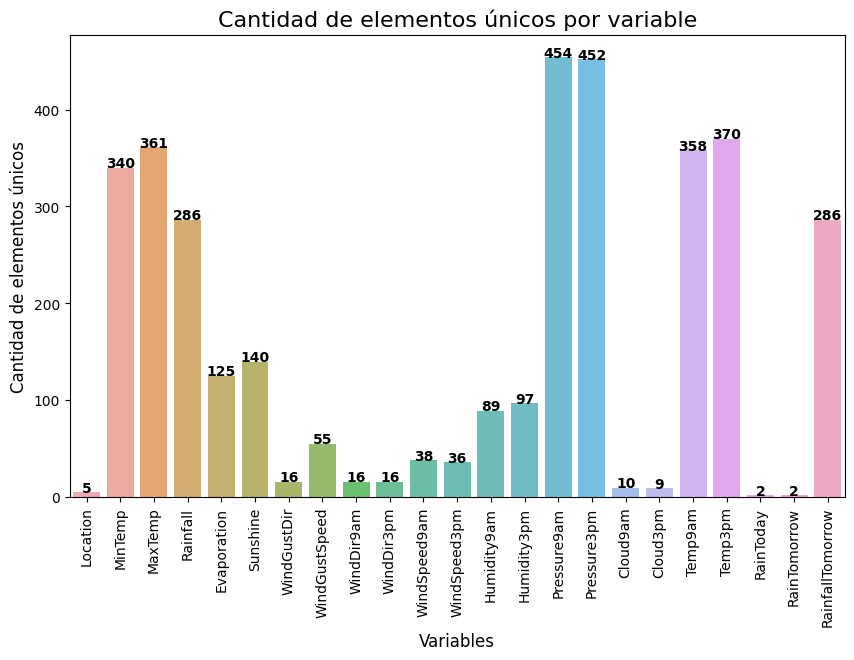

In [ ]:
def graficar_elementos_unicos(df):
    n_unicos = df.nunique() # obtiene el numero de valores unicos de cada variable

    plt.figure(figsize=(10, 6))
    bar_unicos = sns.barplot(x=n_unicos.index, y=n_unicos.values, alpha=0.8) # grafico en barplot

    plt.ylabel('Cantidad de elementos únicos', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.title('Cantidad de elementos únicos por variable', fontsize=16)
    plt.xticks(rotation='vertical')

    # Agrega la cantidad de elementos únicos a cada barra
    for i, v in enumerate(n_unicos):
        bar_unicos.text(i, v + 0.2, str(v), color='black', fontweight='bold', ha='center')

    plt.show()

graficar_elementos_unicos(df_filtrado.drop('Date', axis=1))

### Binarización

Hemos notado dos columnas que son binarias en conjunto de datos. Pero que estas representan clases en forma de string. Para incluirlas al analisis podemos representarlas como numeros discretos binarios, 1 y 0.


In [ ]:
def binarize_cols(cols):
    cols_bin = cols.copy()  # Crear una copia para no modificar el DataFrame original
    cols_bin = cols_bin.eq('Yes').mul(1)
    cols_bin[cols.isna()] = np.nan  # Restaurar los valores NaN
    return cols_bin

display(df_filtrado['RainToday'].unique())
df_filtrado[binarias] = binarize_cols(df_filtrado[binarias])
display(df_filtrado['RainToday'].unique())

array(['Yes', 'No', nan], dtype=object)

array([ 1.,  0., nan])

### Discretización del tiempo

En principio, es intuituvo que si interesa conocer como la lluvia actua sobre estas ciudades, el tiempo es importante. Pero como contamos solo con la variable de cada fecha, utilizamos la siguiente funcion para obtener de ella el año, el mes (en forma de string en ingles, para no confundirla con una variable ordinal), y la estacion del año de cada registro.


In [ ]:
def procesar_fecha(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date']) # convierte el tipo

    df['Year'] = df['Date'].dt.year # obtiene el año y mes
    df['Month'] = df['Date'].dt.month
    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[x]) # mapea el numero del mes a su nombre

    conditions = [
        (df['Month'].isin(['December', 'January', 'February'])),  # Verano
        (df['Month'].isin(['March', 'April', 'May'])),            # Otoño
        (df['Month'].isin(['June', 'July', 'August'])),           # Invierno
        (df['Month'].isin(['September', 'October', 'November']))  # Primavera
    ]

    seasons = ['Summer', 'Autumn', 'Winter', 'Spring'] # se agregan las estaciones
    df['Season'] = np.select(conditions, seasons, default='Unknown')

    return df

df_seasons = procesar_fecha(df_filtrado)

Con esto, aparecen tres nuevas variables categoricas agregadas al dataframe.

In [ ]:
display(df_seasons.head(1))
categoricas = categoricas + ['Year', 'Month', 'Season']

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Year,Month,Season
0,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,8.0,8.0,20.7,20.9,1.0,1.0,6.0,2008,February,Summer


### Separación de los datos


Es recomendable hacer la separacion del conjunto de datos en las partes de entrenamiento y validacion en este punto para evitar completamente la contamicacion de los datos de validacion en los datos de entrenamiento. Las tranformaciones anteriores no tienen este problema debido a que son transformaciones que actuaran de igual manera en cualquier contexto de este dataframe.

Tenemos dos problemas generales para resolver. Uno es la estimacion de la variable continua 'RainfallTomorrow' y el otro es la estimacion de la clase binaria 'RainTomorrow'.

Para facilitar la separacion de los conjuntos de datos para los distintos objetivos, primero comprobamos el hecho de que siempre que haya un registro nulo para 'RainfallTomorrow', siempre sera nulo el mismo registro para 'RainTomorrow', y viceversa.


In [ ]:
# Filtrar registros donde 'RainfallTomorrow' es nulo y 'RainTomorrow' no es nulo
condition1 = df_seasons['RainfallTomorrow'].isnull() & ~df_seasons['RainTomorrow'].isnull()
subset1 = df_seasons[condition1]

# Filtrar registros donde 'RainTomorrow' es nulo y 'RainfallTomorrow' no es nulo
condition2 = ~df_seasons['RainfallTomorrow'].isnull() & df_seasons['RainTomorrow'].isnull()
subset2 = df_seasons[condition2]

# Filtrar registros donde 'RainfallTomorrow' es nulo y 'RainTomorrow' es nulo
condition3 = df_seasons['RainfallTomorrow'].isnull() & df_seasons['RainTomorrow'].isnull()
subset3 = df_seasons[condition3]

# Filtrar registros donde 'RainTomorrow' no es nulo y 'RainfallTomorrow' no es nulo
condition4 = ~df_seasons['RainfallTomorrow'].isnull() & ~df_seasons['RainTomorrow'].isnull()
subset4 = df_seasons[condition4]


# Mostrar los resultados
print("Registros donde 'RainfallTomorrow' es nulo y 'RainTomorrow' no es nulo:")
print(subset1.shape)

print("\nRegistros donde 'RainTomorrow' es nulo y 'RainfallTomorrow' no es nulo:")
print(subset2.shape)

# Mostrar los resultados
print("\nRegistros donde 'RainfallTomorrow' nulo y 'RainTomorrow' es nulo:")
print(subset3.shape)

print("\nRegistros donde 'RainTomorrow' no es nulo y 'RainfallTomorrow' no es nulo:")
print(subset4.shape)

print('\nLongitud total del conjunto:', df_seasons.shape)
print('\nSuma de conjuntos ambos nulos y ambos no nulos: ', (subset4.shape[0] + subset3.shape[0]))

Registros donde 'RainfallTomorrow' es nulo y 'RainTomorrow' no es nulo:
(0, 27)

Registros donde 'RainTomorrow' es nulo y 'RainfallTomorrow' no es nulo:
(0, 27)

Registros donde 'RainfallTomorrow' nulo y 'RainTomorrow' es nulo:
(787, 27)

Registros donde 'RainTomorrow' no es nulo y 'RainfallTomorrow' no es nulo:
(15199, 27)

Longitud total del conjunto: (15986, 27)

Suma de conjuntos ambos nulos y ambos no nulos:  15986


Esto es de gran interes, debido a que significa que para ambos problemas podemos compartir el mismo conjunto de datos para entrenamiento y testing.

Notemos que hay 787 registros solamente que tienen valores nulos en al menos una de las variables objetivos. Y que particularmente en estos registros, los nulos aparecen simultanemente en ambas variables.

Nosotros no debemos incluir estos registros en nignuno de los datos de entranamiento ni validacion, debido a que los modelo no pueden procesar valores nulos. Pero imputar estos valores nulos durante el procesamiento podria tener un impacto negativo debido a que estas variables son de principal interes para los problemas como para ocupar esos nulos con datos falsos. Por lo tanto estos registros particulares seran apartados para ser predichos por los modelos formales que desarrollaremos, ya que su objetivo es justamente la capacidad de predecir estas variables.

Por lo que se obtiene un total de 7 conjuntos de datos:
- X_train: Sera el conjunto de entrenamiento comun a ambos problemas.
- X_test: Sera el conjunto de validacion comun a ambos problemas.
- y_train: Sera la variable objetivo de entrenamiento correspondiente al problema de regresion.
- y_train_clasif: Sera la variable objetivo de entrenamiento correspondiente al problema de clasificacion.
- y_test: Sera la variable objetivo de validacion correspondiente al problema de regresion.
- y_test_clasif: Sera la variable objetivo de validacion correspondiente al problema de clasificacion.
- X_reserva: Sera el conjunto de variables explicativas que usaramos para realizar predicciones finales con ambos modelos de clasifiacion y regresion.


In [ ]:
def separar_registros(df):

    df_sin_nulos = df.dropna(subset=['RainTomorrow', 'RainfallTomorrow'])
    df_con_nulos = df[df[['RainTomorrow', 'RainfallTomorrow']].isnull().any(axis=1)]

    X_reserva = df_con_nulos.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)

    X = df_sin_nulos.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1)
    y = df_sin_nulos['RainfallTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_train_clasif = df_sin_nulos.loc[y_train.index , 'RainTomorrow']
    y_test_clasif = df_sin_nulos.loc[y_test.index , 'RainTomorrow']

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    X_reserva = X_reserva.reset_index(drop=True)
    y_train_clasif = y_train_clasif.reset_index(drop=True)
    y_test_clasif = y_test_clasif.reset_index(drop=True)

    return X_train, X_test, y_train, y_test, y_train_clasif, y_test_clasif, X_reserva

X_train, X_test, y_train, y_test, y_train_clasif, y_test_clasif, X_reserva = separar_registros(df_seasons)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_train_clasif.shape, y_test_clasif.shape)
print(X_reserva.shape)

(12159, 25) (3040, 25)
(12159,) (3040,)
(12159,) (3040,)
(787, 25)


In [ ]:
X_reserva.to_csv('X_reserva.csv', index=False)

# **Análisis Descriptivo**

Esta seccion trata de generar interpretabilidad de las variables y descubrir tendencias y patrones visuales en los datos para entender el contexto de los problemas.

### Correlaciones


El estudio de las correlaciones lineales de las variables con las demas variables es importante para notar relaciones simples entre los datos.

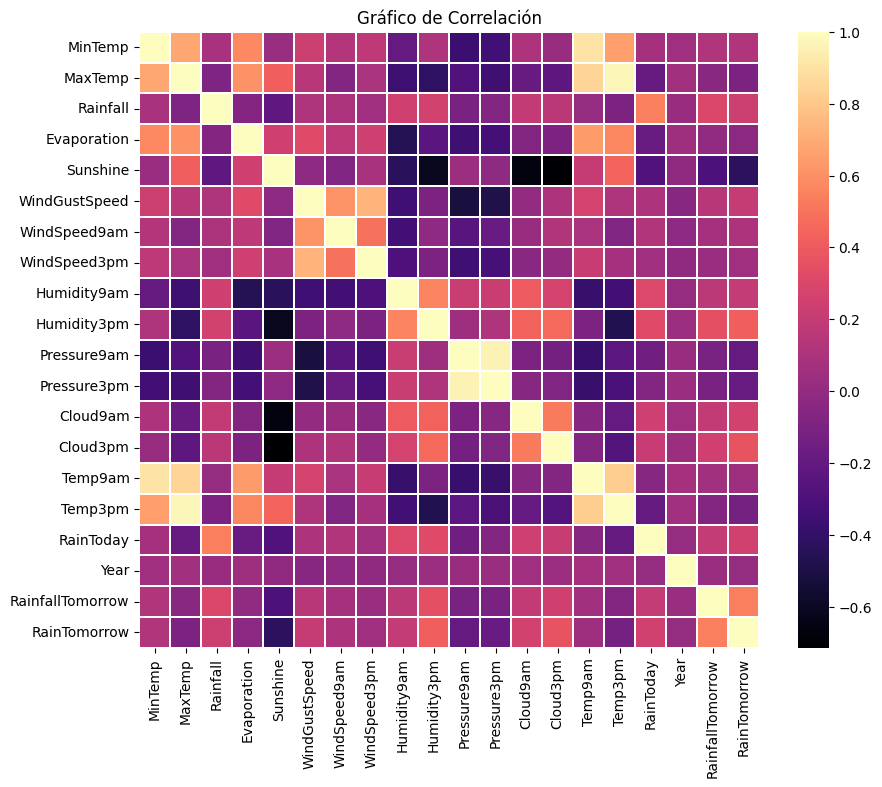

In [ ]:
def graph_corr(df):
  correlation_matrix = df.corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=False, cmap='magma', linewidths=0.3)
  plt.title('Gráfico de Correlación')
  plt.show()

graph_corr(pd.concat([X_train, y_train, y_train_clasif], axis=1))

En este caso, la variable objetivo no tiene mucha correlacion lineal con las demas variables. De hecho, en valor absoluto, los valores son bajos para esta variable. Esto sugiere que un modelo lineal no puede explicar de buena forma el comportamiento de esta variable objetivo de la regresion.

Notamos cosas interesantes que la intucion ayuda a comprobar:
- Correlaciones negativas entre variables que representan humedad o oscuridad y variables con luminocidad y altas temperaturas.
- Correlaciones entre las temperaturas con humedad o presion.


### Proporciones binarias

El siguiente grafico tiene la intencion de demostrar la proporcion de dias lluviosos y no lluviosos del dia siguiente, en base a si ha llovido el dia actual o no.


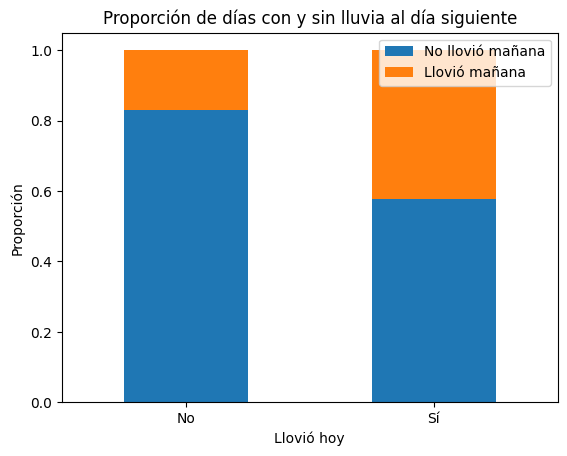

In [ ]:
# Crear una tabla de contingencia (tabla de conteo de frequencias de clases)
contingency_table = pd.crosstab(X_train['RainToday'], y_train_clasif)

# Calcular las proporciones
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Crear el gráfico de barras
proportions.plot(kind='bar', stacked=True)

plt.title('Proporción de días con y sin lluvia al día siguiente')
plt.xlabel('Llovió hoy')
plt.ylabel('Proporción')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.legend(['No llovió mañana', 'Llovió mañana'])

plt.show()

Este grafico insinua que en mas del 80% de los casos que no llueve el dia actual, tampoco llueve el dia siguiente. Y para aquellos dias que si llovio, en mas del 50% de los casos ha llovido el dia siguiente.

### Distribuciones binarias

El suguiente grafico tiene intencion de ser interactivo con el fin de entender el comportamiento de cada variable individualmente con respecto a la presencia de lluvia.

In [ ]:
def create_plots(d, explanatory_var, binary_var):
    df = pd.concat([d, y_train_clasif, y_train], axis=1)
    df = df.dropna()

    fig, axs = plt.subplots(3, 1, figsize=(6,6))

    # es un grafico de una sola dimension que le da grosor en el eje y solo por facilidad de visualizacion, separa las clases en colores
    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=binary_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + binary_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    # crea distribucion en boxplot de la variable separado por clase
    sns.boxplot(y=binary_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    # distribuciones de densidad por clases
    sns.kdeplot(data=df, x=explanatory_var, hue=binary_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

# Crear selector de variable explicativa
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in X_train.columns if col not in categoricas + datetime + binarias],
    value='Sunshine',  # Valor predeterminado
    description='Explicativa:',
)

# crear selector de variable binaria
binary_var_widget = widgets.Dropdown(
    options=['RainToday', 'RainTomorrow'],
    value='RainToday',  # Valor predeterminado
    description='Binaria:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_plots, d=widgets.fixed(X_train), explanatory_var=explanatory_var_widget, binary_var=binary_var_widget)

interactive(children=(Dropdown(description='Explicativa:', index=4, options=('MinTemp', 'MaxTemp', 'Rainfall',…

<function __main__.create_plots(d, explanatory_var, binary_var)>

Notamos por ejemplo, como para la variable Sunshine se puede segmentar la presencia de lluvia en ambas variable binarias. Esto suguiere que esta variable es un buen predictor para el problema de clasificacion.

Ocurre lo mismo con Cloud y Humidity. Para el resto de variables, no puede segmentar en dos grupos distiguidos entre presencia o no de lluvia.

### Distribuciones continuas

El siguiente es un diagrama de RainCloud ya que representa en un a nube la densidad de datos es cada rango de valores de la variable elegida en el widget. Ademas de mostrar cada dato inidividual como su fuera 'lluvia' que tambien representa la densidad de datos de las regiones.

In [ ]:
def create_dist(X_train, y_train, variable):
    df = pd.concat([X_train, y_train], axis=1)
    df = df.dropna(subset=[variable])

    # Crear un diccionario de colores únicos para cada variable
    color_dict = {col: color for col, color in zip(df.columns, sns.color_palette("hsv", len(df.columns)))}

    fig, ax = plt.subplots(figsize=(10, 4))

    # Violin plot (nubes)
    vp = ax.violinplot(df[variable], positions=[0.8], vert=False,
                       showmeans=False, showextrema=False, showmedians=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(color_dict[variable])
    vp['bodies'][0].set_alpha(0.5)

    # Scatter plot (lluvia)
    y = np.full(len(df[variable]), 0.70) + np.random.uniform(low=-.1, high=.1, size=len(df[variable]))
    ax.scatter(df[variable], y, s=8, color=color_dict[variable], alpha=0.2)

     # Boxplot
    bp = ax.boxplot(df[variable], patch_artist=True, vert=False,
                    positions=[0.8],  # Posición del boxplot en el eje vertical
                    boxprops=dict(linewidth=0.2, color='black', alpha=0.5),
                    whiskerprops=dict(linewidth=0.2, color='black', alpha=0.5),
                    flierprops=dict(markerfacecolor='white', markeredgecolor='black', marker='o', markersize=4, alpha=0.1))
    bp['boxes'][0].set_facecolor(color_dict[variable])
    bp['boxes'][0].set_alpha(0.2)

    # Configurar títulos y etiquetas
    ax.set_title(variable)
    ax.set_yticks([])
    ax.set_xlabel("Value")

    plt.show()

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in pd.concat([X_train, y_train], axis=1).columns if col not in categoricas + datetime + binarias],
    description='Variable:',
)

# Usar interact para crear y actualizar el gráfico en un cambio
interact(create_dist, X_train=widgets.fixed(X_train), y_train=widgets.fixed(y_train), variable=variable_widget)

interactive(children=(Dropdown(description='Variable:', options=('MinTemp', 'MaxTemp', 'Rainfall', 'Evaporatio…

<function __main__.create_dist(X_train, y_train, variable)>

Notamos en general precensia de valores atipicos en casi todas las variables. En las distribuciones mas normales no parece preocupante por que en la naturaleza suelen ocurrir grandes subidas o bajadas de variables debido a muchos factores.

Pero hay otras variables mas asimetricas que presentan valores atipicos muy grandes respecto a la mayoria de datos.

### Series de tiempo

Este analisis tiene la intencion de mostrar de forma dinamica en un rango de fechas como ha variado una variable.

Estas funciones hacen uso de suavizadores para facilitar la visualizacion de las lineas de tiempo.

In [ ]:
# Prepar Date como datetime y luego a timestampp para ser interpretado por el grafico
df_weather_ranges = pd.concat([X_train, y_train], axis=1)
df_weather_ranges['Date'] = pd.to_datetime(df_weather_ranges['Date'])
df_weather_ranges['Date'] = df_weather_ranges['Date'].astype(int) // 10**9

def smooth_columns_rolling(df, columns, window_size=3):
    # toma columnas de un dataframe y las suaviza con una intensidad dada
    df_copy = df.copy()
    df_copy = df_copy.sort_values(by='Date')

    for col in columns:
        df_copy[col] = df_copy[col].rolling(window=window_size, min_periods=1).mean()

    return df_copy

def plot_weather_timeseries(df, start_date, end_date, city, variable, window_size):
    fig, ax = plt.subplots(figsize=(10, 5))

    # mapa de colores para las localidades
    location_colors = {'Sydney': '#54BAB9', 'SydneyAirport': '#9ED2C6', 'Melbourne': '#7286D3', 'MelbourneAirport': '#8EA7E9', 'Canberra': '#F675A8'}

    # muestra todas las localidades a le vez, suviadas y originales de fondo
    if city == 'Todas':
        # filtros de fecha
        df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
        df_filtered = df_filtered.sort_values('Date')

        for unique_city in df['Location'].unique():
            city_data = df_filtered[df_filtered['Location'] == unique_city] # orignal
            city_smoothed = smooth_columns_rolling(city_data, [variable], window_size=window_size) # suavizada

            ax.plot(city_data['Date'], city_data[variable], alpha=0.1, color=location_colors[unique_city])
            ax.plot(city_data['Date'], city_smoothed[variable], label=f'{unique_city}', color=location_colors[unique_city])

    else:
        # filtros de fecha y localidad
        df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
        df_filtered = df_filtered[df_filtered['Location'] == city]
        df_filtered = df_filtered.sort_values('Date')

        # suaviza la variable
        smoothed = smooth_columns_rolling(df_filtered, [variable], window_size=window_size)

        ax.plot(df_filtered['Date'], df_filtered[variable], color='lightgray', alpha=0.5)
        ax.plot(df_filtered['Date'], smoothed[variable], label=city, color=location_colors[city])

    ax.set_ylabel(variable)
    ax.legend()

    # Configuración de los ticks y etiquetas del eje x
    date_ticks = [start_date, end_date]
    date_labels = [pd.to_datetime(date_ticks[0], unit='s').strftime('%Y-%m-%d'), pd.to_datetime(date_ticks[1], unit='s').strftime('%Y-%m-%d')]

    ax.set_xticks(date_ticks)
    ax.set_xticklabels(date_labels)

    plt.show()

# rango de valores validos para la fecha
min_date = df_weather_ranges['Date'].min()
max_date = df_weather_ranges['Date'].max()

# vairables validas para suavizar (no categorias)
variable_dropdown = widgets.Dropdown(
    options=[col for col in df_weather_ranges.columns if col not in categoricas + binarias + datetime + discretas],
    description='Variable:',
)

# selector de localidad
city_dropdown = widgets.Dropdown(
    options=['Todas'] + df_weather_ranges['Location'].unique().tolist(),
    description='Ciudad:',
)

# selector de rango de fechas
date_range_slider = widgets.IntRangeSlider(
    min=min_date,
    max=max_date,
    description='Date Range:',
    continuous_update=False,
)

# selector de intensidad del suavizado
window_size_slider = widgets.IntSlider(
    min=1,
    max=50,
    step=1,
    value=20,
    description='Window Size:',
)

def update_plot(date_range, city, variable, window_size):
    start_date, end_date = date_range
    plot_weather_timeseries(df_weather_ranges, start_date, end_date, city, variable, window_size)

widgets.interact(update_plot, date_range=date_range_slider, city=city_dropdown, variable=variable_dropdown, window_size=window_size_slider)

interactive(children=(IntRangeSlider(value=(1269972000, 1422165600), continuous_update=False, description='Dat…

<function __main__.update_plot(date_range, city, variable, window_size)>

Podemos analizar tendencias y patrones de las variables a lo largo del periodo seleccionado, en su mayoria son patrones ciclicos. Notar por ejemplo grandes subidas de temperatura o lluvias en ciertos periodos.

En general no se nota gran variabilidad de las variables con respecto a las localidades. Esto es de esperar, ya que las localidades estan relativamente cerca las unas de las otras. Pero notar por ejemplo como Sydney y Sydney Airport son muy similares, aunque no en Melbourne y MelbourneAirport se distancias levemente.

# **Tratamiento Primario**


En esta seccion se realizan transformaciones sobre los datos.
Es importante notar que se sigue un enfoque modular. Es decir, todo se realiza mediante transformaciones a traves de funciones que retornan copias modificadas de conjunto de datos original.

De esta manera, es posible descartar o volver hacia atras facilmente cuando una transformacion no resulta de utilidad, o no se decide incluir al conjunto final.

### Modelo base para regresión lineal

Se establece un modelo de regresion lineal basico. Este sera de gran utilidad para evaluar como cambia al modelo una transformacion del conjunto de datos. Es importante considerar que este modelo no es un modelo ingenuo como tal, donde su objetivo es mejorar su rendimiento. Este modelo en realidad tiene la intecion de comprobar que las estimaciones mejoren de a acuerdo a las transformaciones del dataset para hacerlo mas explicativo.

Notar que toma un conjunto de datos y la variable objetivo. El como realiza la regresion es simple, toma todas las variables del dataframe que no tengan nulos ni categorias (para que no se rompa el modelo), entrena el modelo, lo valida, y retorna una muestra del dataframe que utilizo para entrenar (de utilidad para saber que variables considera), y dos metricas: MSE y R2.

In [ ]:
def base_linear_regression(X_train, X_test, y_train, y_test):
    # elimino datos futuros si los hubiera
    if 'RainTomorrow' in X_train.columns or 'RainTomorrow' in X_test.columns:
        X_train = X_train.drop('RainTomorrow', axis=1)
        X_test = X_test.drop('RainTomorrow', axis=1)

    # me quedo con las columnas numericas
    X_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    X_train = X_train[X_numeric_cols]
    X_test = X_test[X_numeric_cols]

    # elimino las filas con valores nulos en X_train y X_test y los correspondientes en y_train y y_test
    X_train_null_indices = X_train[X_train.isnull().any(axis=1)].index
    X_train = X_train.dropna()
    y_train = y_train.drop(X_train_null_indices)

    X_test_null_indices = X_test[X_test.isnull().any(axis=1)].index
    X_test = X_test.dropna()
    y_test = y_test.drop(X_test_null_indices)

    # muestra del conjunto usado
    print('Muestra conjunto de entrenamiento: ')
    display(pd.concat([X_train, y_train], axis=1).head(1))

    # modelo basica de regresion lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('\nMuestra prediccion: ')
    display(pd.DataFrame({'Valor Real': y_test, 'Prediccion': y_test_pred}).head(1))

    # obtiene las metricas de validacion
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    # crea un DataFrame con los resultados
    results_df = pd.DataFrame({
        'Set': ['Train', 'Test'],
        'R2': [round(r2_train, 3), round(r2_test, 3)],
        'RMSE': [round(rmse_train, 3), round(rmse_test, 3)]
    })

    # imprime los resultados de validacion
    print('\nMetricas de validacion: ')
    display(results_df)

In [ ]:
base_linear_regression(X_train, X_test, y_train, y_test)

Muestra conjunto de entrenamiento: 


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,RainfallTomorrow
0,6.4,13.1,0.0,0.8,0.0,78.0,15.0,24.0,76.0,77.0,1022.7,1019.8,8.0,8.0,11.2,12.0,0.0,2011,1.2



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,5.142146



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.206,6.021
1,Test,0.214,6.745


Estos valores seran nuestra base para saber si a lo largo de las transformaciones, el dataframe mejora la forma de entrenamiento del modelo o no.

Notamos en principio, que el modelo en el caso ejemplo subestima la cantidad de lluvia. Las metricas son muy bajas, y notamos algo de subajuste.

### Modelo base de clasificación

En este caso si contamos con el siguiente modelo de clasificacion base para la estimacion de la presencia de lluvia para el dia posterior a un registro dado.

Su enfoque de estimacion es muy simple: Estimar que el dia posterior llovera si el dia actual llueve. Caso contrario, estima que no llueve.

Notar tambien que nos deshacemos de las variables categoricas (a excepcion de RainToday que es vital para la estimacion) y de los registros que presentan valores nulos.

In [ ]:
def base_model_clasification(X_train, X_test, y_train, y_test):
    # elimino las filas con valores nulos en X_train y X_test y los correspondientes en y_train y y_test
    X_train_null_indices = X_train[X_train.isnull().any(axis=1)].index
    X_train = X_train.dropna()

    X_test_null_indices = X_test[X_test.isnull().any(axis=1)].index
    X_test = X_test.dropna()

    y_test = pd.Series(y_test).drop(X_test_null_indices)
    y_train = pd.Series(y_train).drop(X_train_null_indices)

    # me quedo con las columnas numericas
    X_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    X_train = X_train[X_numeric_cols]
    X_test = X_test[X_numeric_cols]

    # muestra del conjunto usado
    print('Muestra conjunto de entrenamiento: ')
    display(pd.concat([X_train, y_train], axis=1).head(1))

    # Prediccion: Si llueve hoy, llueve manana, sino llueve hoy, no llueve manana
    y_train_pred = X_train['RainToday']
    y_pred = X_test['RainToday']

    print('\nMuestra prediccion: ')
    display(pd.DataFrame({'Valor Real': y_test, 'Prediccion': y_pred}).head(1))

    # Calcular las métricas de clasificación
    metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [round(accuracy_score(y_train, y_train_pred), 3),
              [round(p, 3) for p in precision_score(y_train, y_train_pred, average=None)],
              [round(r, 3) for r in recall_score(y_train, y_train_pred, average=None)],
              round(f1_score(y_train, y_train_pred), 3)],
    'Test': [round(accuracy_score(y_test, y_pred), 3),
             [round(p, 3) for p in precision_score(y_test, y_pred, average=None)],
             [round(r, 3) for r in recall_score(y_test, y_pred, average=None)],
             round(f1_score(y_test, y_pred), 3)]
    })

    print('\nMetricas de validacion: ')
    display(metrics)

# Llamada a la función
base_model_clasification(X_train, X_test, y_train_clasif, y_test_clasif)

Muestra conjunto de entrenamiento: 


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,RainTomorrow
0,6.4,13.1,0.0,0.8,0.0,78.0,15.0,24.0,76.0,77.0,1022.7,1019.8,8.0,8.0,11.2,12.0,0.0,2011,1.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.726,0.727
1,Precision,"[0.823, 0.416]","[0.822, 0.423]"
2,Recall,"[0.818, 0.424]","[0.819, 0.428]"
3,F1 Score,0.42,0.426


Es de esperar que las metricas de clasificacion usando este modelo y dataset no procesado sean bajas, pero la intencion es usar estas mismas como base para indicarnos si posteriores modelos mas avanzados no resulten menos efectivos que este modelo basico.

Notamos por las metricas de presicion y recall que se estan teniendo mejores metricas en una clases que en la otra. Esto sugiere un fuerte desbalanceo de la categoria.

### Codificación de variables categoricas


En esta seccion se busca incluir las columnas categoricas en forma de string al modelo. Creemos que el modelo puede enriquecerce al conocer contextualmente las clases de estas variables.

Es decir, incluir a sus variables de entrenamiento informacion como la localidad, la estacion del año, las direcciones del veinto, etc.

Para ello, la forma de codificar la variables es mediante una codificacion frecuencial. Esto significa que asignara a cada clase un numero que represente la cantidad de sus apariciones a lo largo del conjunto de datos.

De esta manera, se evitan generar muchas columnas nuevas con el enfoque de OneHotEncoding, y el modelo lineal no interpreta directamente una clase mayor que otra a menos que note que tiene mayor aparicion en el conjunto.

In [ ]:
def frequency_encode_categorical(df, mapping_dict=None):
    df_copy = df.copy()

    if mapping_dict is None:
        # Conjunto de entrenamiento: codificar y crear el diccionario
        mapping_dict = {}
        non_nums = df_copy.select_dtypes(include=[object])

        for column in non_nums.columns:
            freq_enc = non_nums[column].value_counts(normalize=True)
            mapping_dict[column] = freq_enc.to_dict()
            df_copy[column] = non_nums[column].map(freq_enc)

        return df_copy, mapping_dict

    else:
        # Conjunto de prueba: usar el diccionario de mapeo existente
        for column, mapping in mapping_dict.items():
            df_copy[column] = df_copy[column].map(mapping)

        return df_copy

Las siguientes funciones tienen la intencion de aumentar y reducir variables para mejorar la explicabilidad y simplificar la informacion.

In [ ]:
# agregar las coordenadas de cada localidad
def add_coord(df):
    # en principio solo de interes para analisis descriptivo. Los datos fueron tomados de internet
    data = {
        'Location': ['Sydney', 'Canberra', 'Melbourne', 'SydneyAirport', 'MelbourneAirport'],
        'lat': [-33.865143, -35.282001, -37.840935, -33.947346, -37.663712],
        'lon': [151.209900, 149.128998, 144.946457, 151.179428, 144.844788]
    }

    au = pd.DataFrame(data)
    df_merged = df.merge(au[['Location', 'lat', 'lon']], left_on='Location', right_on='Location', how='inner')

    return df_merged


# de interes para simplificar las tantas clases de las direcciones del viento de 16 a 8
def mapear_direcciones_viento(df):
    df = df.copy()
    mapeo = {
        'N': 'N', 'NNE': 'N', 'NNW': 'N',
        'E': 'E', 'ENE': 'E', 'ESE': 'E',
        'S': 'S', 'SSE': 'S', 'SSW': 'S',
        'W': 'W', 'WSW': 'W', 'WNW': 'W',
        'NW': 'NW', 'NE': 'NE', 'SE': 'SE', 'SW': 'SW'
    } # usa mapeos predefinidos manualmente

    columnas_viento = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
    for columna in columnas_viento:
        df[columna] = df[columna].replace(mapeo)
    return df


# simplicar las ciudades. Sabemos y notamos por coordenadas, que los aeropuertos de las ciudades son muy cercanos a sus ciudades (de hecho pertecen a ahi), por lo que podriamos simplificar
def mapear_localidades(df):
    df = df.copy()
    mapeo = {'SydneyAirport': 'Sydney',
             'MelbourneAirport': 'Melbourne'} # mapeo manual

    df['Location'] = df['Location'].replace(mapeo)
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
X_train_vientos = mapear_direcciones_viento(X_train) # se simplifican las dirreciones del viento
X_test_vientos = mapear_direcciones_viento(X_test)

X_train_locations = mapear_localidades(X_train) # se simplifican las localidades
X_test_locations = mapear_localidades(X_test)

X_train_coors = add_coord(X_train_locations) # se añiaden las coordenadas de las localidades
X_test_coors = add_coord(X_test_locations)

# notar que salteamos las coordenadas y ña simplificaion del viento debido al impacto negativo en el modelo base.
X_train_encodes, encoder_cats = frequency_encode_categorical(X_train_locations) # se codifican las variables
X_test_encodes = frequency_encode_categorical(X_test_locations, encoder_cats)

In [ ]:
base_linear_regression(X_train_encodes, X_test_encodes, y_train, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Season,RainfallTomorrow
0,0.360145,6.4,13.1,0.0,0.8,0.0,0.146299,78.0,0.161501,0.090398,...,1019.8,8.0,8.0,11.2,12.0,0.0,2011,0.085862,0.254379,1.2



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,5.388969



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.208,6.037
1,Test,0.217,6.740


Aqui se prueban distintas alternativas de que forma es mas performante el modelo ahora que incluye las variables categoricas.

La simplificacion de la variable Location resulta favorable. En cambio la simplificacion de las direcciones del viento no implica perdida significativa de valor, pero si reduce levemente las metricas de validacion.

Notamos como el modelo no ha mejorado ampliamente luego de inluir informacion de las categorias al dataframe de entrenamiento. Es muy poca la mejora en las metricas de validacion. Esto puede sugerir que las variables categoricas de este dataset no estan aportando gran informacion para entender la variable objetivo.

Notar que obviamos el hecho usar las coordenadas en el entrenamiento debido a que impactan muy negativamente al modelo.

### Tratamiento de valores nulos

Este dataset contiene valores nulos en las distintas variables. Podemos notarlo en el siguiente grafico.

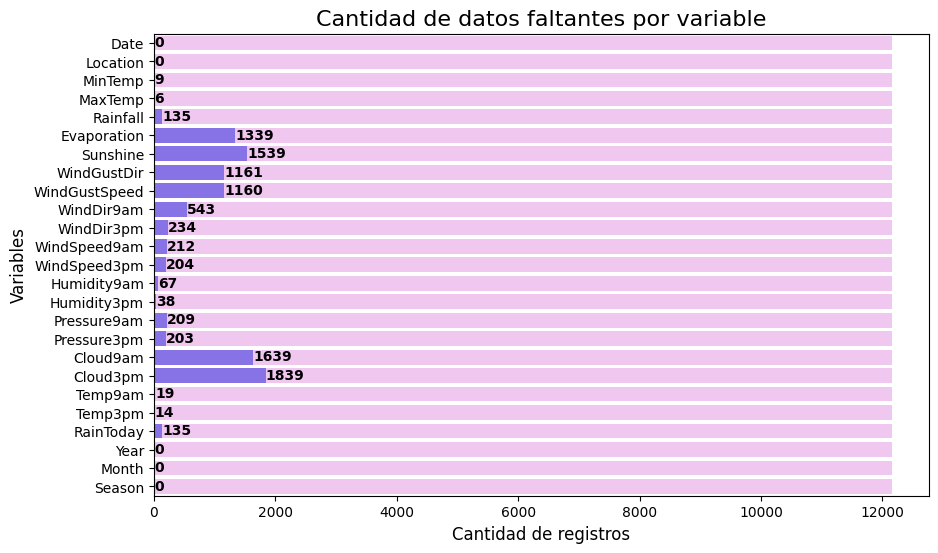

In [ ]:
def graficar_datos_faltantes(df):
    df = df.copy()
    total = df.shape[0]
    nulos = df.isnull().sum() # obtiene todos los nulos

    df_grafico = pd.DataFrame({'total': total, 'nulos': nulos}) # genera un dataframe de forma temporal

    plt.figure(figsize=(10, 6))
    sns.barplot(y=df_grafico.index, x=df_grafico['total'], color='violet', alpha=0.5) # bar que muestra todos los registros
    bar_nulos = sns.barplot(y=df_grafico.index, x=df_grafico['nulos'], color='blue', alpha=0.5) # bar que muestra solo los nulos

    plt.xlabel('Cantidad de registros', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Cantidad de datos faltantes por variable', fontsize=16)

    # Agrega la cantidad de valores nulos a cada barra
    for i, v in enumerate(df_grafico['nulos']):
        bar_nulos.text(v + 0.2, i + .2, str(v), color='black', fontweight='bold')

    plt.show()

graficar_datos_faltantes(X_train_encodes)

Tanto las variables categoricas como numericas contienen valores nulos. Por eso es importante tratarlas de forma diferente.

Separaremos las columnas para realizar imputaciones con diferentes enfoques.

In [ ]:
numerical_nulls = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
categorical_nulls = ['WindGustDir','WindDir9am','WindDir3pm', 'RainToday', 'Cloud9am', 'Cloud3pm']

Para imputar las variables, se utilizara un modelo externo al cursado: K-Nearest Neighbours.

Este modelo basicamente realiza estimaciones de valores utilizando una media de los registros que se le parecen.

Es decir, mide la distancia entre el registro que quiere imputar y todos los demas. Aquella cantidad k de registros que consideremos como vecinos cercanos, seran seleccionadas para hacer una media de los valores de la variable que se busca imputar.

Para este caso particular, utilizaremos este algoritmo para imputar tanto las variables categoricas como las numericas, debido a que para este punto, todas las variables fueron codificadas, por lo tanto, todas las variables son numericas. Pero se usaran diferentes imputadores para ambos tipos de variables para no generar clases que no existen en vairables categoricas.

De esta manera se logra una imputacion mas contextual de los valores nulos, ya que enfoques mas simples como imputar todos los datos con una media global, o simplemente remover los valores nulos del conjunto, pueden causar gran perida de informacion.

In [ ]:
def impute_knn(df, nums=None, cats=None, knn_imputer=None):
    df_copy = df.copy()

    if not knn_imputer:
        if nums:
            imputer = KNNImputer(n_neighbors=10) # a este hiperparametros lo ajustamos para maximizar el rendimiento del modelo base
            df_copy[nums] = imputer.fit_transform(df_copy[nums])
            return df_copy, imputer
        elif cats:
            imputer = KNNImputer(n_neighbors=1)
            df_copy[cats] = imputer.fit_transform(df_copy[cats])
            return df_copy, imputer
    else:
        if nums:
            df_copy[nums] = knn_imputer.transform(df_copy[nums])
            return df_copy
        elif cats:
            df_copy[cats] = knn_imputer.transform(df_copy[cats])
            return df_copy

X_train_num_imputed, knn_imputer_nums = impute_knn(df=X_train_encodes, nums=numerical_nulls)
X_test_num_imputed = impute_knn(df=X_test_encodes, nums=numerical_nulls, knn_imputer=knn_imputer_nums)

X_train_imputed, knn_imputer_cats = impute_knn(df=X_train_num_imputed, cats=categorical_nulls)
X_test_imputed = impute_knn(df=X_test_num_imputed, cats=categorical_nulls, knn_imputer=knn_imputer_cats)

Podemos validar para este punto que el dataframe transformado no posee nulos.

In [ ]:
nulos = X_train_imputed.isnull().sum()
nulos[nulos > 0]

Series([], dtype: int64)

In [ ]:
base_linear_regression(X_train_imputed, X_test_imputed, y_train, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Season,RainfallTomorrow
0,0.360145,6.4,13.1,0.0,0.8,0.0,0.146299,78.0,0.161501,0.090398,...,1019.8,8.0,8.0,11.2,12.0,0.0,2011,0.085862,0.254379,1.2



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,4.700998



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.229,6.378
1,Test,0.228,6.890


El rendiemiento del modelo base ha mejorado en sus metricas de validacion con esta transformacion, por lo que el enfoque de inputacion con este algoritmo resulta favorable.

Notar incluso que se ha reducido la brecha en las metricas para train y test, y aunque el modelo paso de simplificar las predicciones con respecto al entrenamiento, a un estado leve de sobreajuste, se encuentra en un estado mas estable entre las metricas de los conjuntos.

Notamos tambien en la muestra de la prediccion que el modelo ahora subestima un poco mas que antes, lo cual no es bueno, pero a nivel global ha mejorado.

In [ ]:
base_model_clasification(X_train_imputed, X_test_imputed, y_train_clasif, y_test_clasif)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Season,RainTomorrow
0,0.360145,6.4,13.1,0.0,0.8,0.0,0.146299,78.0,0.161501,0.090398,...,1019.8,8.0,8.0,11.2,12.0,0.0,2011,0.085862,0.254379,1.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.731,0.745
1,Precision,"[0.824, 0.426]","[0.832, 0.447]"
2,Recall,"[0.825, 0.425]","[0.838, 0.436]"
3,F1 Score,0.425,0.441


El rendimiento para el modelo base de clasificacion en cambio no presenta diferencias significativas.

In [ ]:
# Guardar modelos
joblib.dump(knn_imputer_nums, 'knn_imputer_nums_model.joblib')
joblib.dump(knn_imputer_cats, 'knn_imputer_cats_model.joblib')

['knn_imputer_cats_model.joblib']

### Suavizado de datos

Una tecnica que puede ser de utilidad para mejorar la interpretabilidad del modelo sobre variables continuas, es la reduccion de variabilidad. Esto a su vez puede ser de utilidad para el tratamiento de valores atipicos en las variables.

El siguiente grafico es un ejemplo de como se comporta la temperatura maxima de cada localidad a lo largo de un año.

In [ ]:
df_2017 = X_train_imputed[X_train_imputed['Year'] == 2017].sort_values(by='Date')

fig = px.line(
    df_2017,
    x='Date',
    y="MaxTemp",
    color="Location",
    hover_name="Location",
)

fig.update_layout(showlegend=False)
fig.show()

Podemos notar gran variabilidad de la misma a lo largo de los dias. Esto podria no ser ventajoso para un modelo de prediccion, ya que interesa captar la esencia de las tendencias y patrones, no el detalle exacto de cada valor.

Una forma de reducir esta volatilidad es suavizar estas series de tiempo.

Para ello se utiliza un kernel o ventana que se desliza hacia la derecha, y obtiene una especie de media de los valores, dandole mas peso a los valores cercanos a la iteracion actual (con una campana de gauss).

Notar que por el tamaño del kernel, quedan datos no capturados por la ventana al inicio, por lo que se rellenan con un enfoque simple, de imputarlos con el valor mas proximo (el primer dia que si entra en el rango de la ventana).

In [ ]:
def plot_smoothed_data(df, df_smoothed, column, year):
    # Filtrar los datos por año y ordenar por 'Date'
    df_year = df[df['Year'] == year].sort_values('Date')
    df_smoothed_year = df_smoothed[df_smoothed['Year'] == year].sort_values('Date')

    # Obtener las ubicaciones únicas
    locations = df['Location'].unique()

    # Crear una figura
    plt.figure(figsize=(10, 6))

    # Dibujar una línea para cada ubicación
    for location in locations:
        df_location = df_year[df_year['Location'] == location]
        df_smoothed_location = df_smoothed_year[df_smoothed_year['Location'] == location]

        # Dibujar los datos no suavizados en gris
        plt.plot(df_location['Date'], df_location[column], color='grey', alpha=0.5)

        # Dibujar los datos suavizados en un color más fuerte
        plt.plot(df_smoothed_location['Date'], df_smoothed_location[column])

    # Mostrar el gráfico
    plt.show()

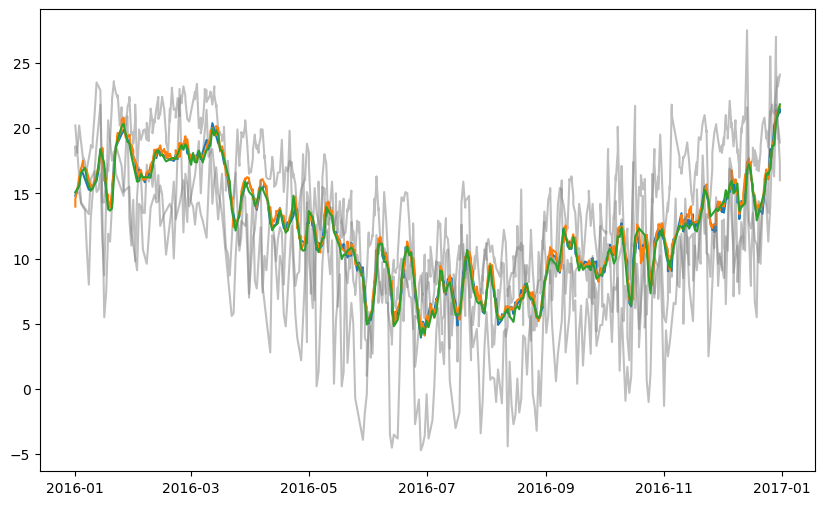

In [ ]:
warnings.filterwarnings("ignore")
X_train_smothed = smooth_columns_rolling(X_train_imputed, ['MinTemp', 'MaxTemp'], window_size=15)
X_test_smothed = smooth_columns_rolling(X_test_imputed, ['MinTemp', 'MaxTemp'], window_size=15)
# X_reserva_smothed = smooth_columns_rolling(df, columns, window_size=3)

plot_smoothed_data(X_train_imputed, X_train_smothed, 'MinTemp', 2016)

De esta manera notamos como reducimos el ruido de estas variables para captar solo las tendencias principales.


In [ ]:
base_linear_regression(X_train_smothed, X_test_smothed, y_train, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Season,RainfallTomorrow
7439,0.223456,8.0,24.3,0.0,3.4,6.3,0.069376,30.0,0.052686,0.066583,...,1015.0,7.0,7.0,14.4,23.6,0.0,2007,0.080763,0.246813,3.6



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,2.064002



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.002,7.257
1,Test,-0.002,7.849


Se han probado distintas combinaciones de variables para suavizar, y concluimos segun las metricas del modelo base, que el suavizado impacta muy negativamente al modelo base. Por lo que se descarta su integracion al conjunto final.

### Estandarización de rangos

Esta funcion es de utilidad para conocer las distribuciones de las variables.

Notamos que hay variables con valores muchos mas grandes que otras, pero no por ser valores atipicos, sino por que las variables en si se miden en rangos distintos.

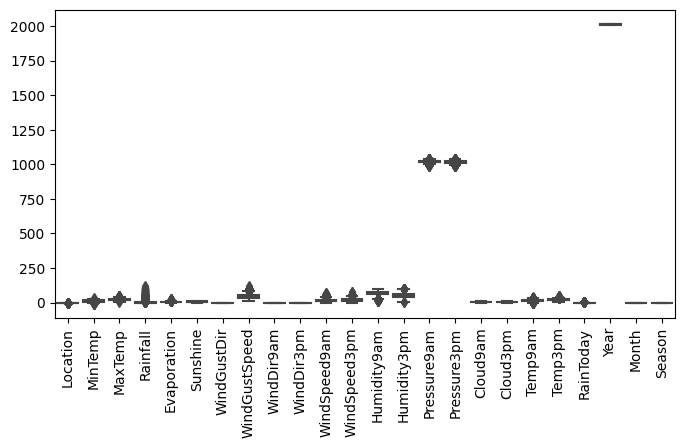

In [ ]:
def show_distrbutions(df):
    plt.figure(figsize=(8, 4))
    sns.boxplot(df)
    plt.xticks(rotation=90)
    plt.show()

show_distrbutions(X_train_imputed)

Probaremos y compararamos con diferentes metodos de escalado y estandarizacion, ya que es importante que los datos sean interpretados por los modelos en la misma escala de valores.

Probamos estandarizar las variables, normalizar su rango de 0 a 1, y escalarlas de forma robusta para diminuir la influencia de los valores atipicos de cada variable.

La siguiente funcion tiene la intecion de abarcar los distintos casos de estandarizacion de datos, pudiendo configurar el caso mediante parametros.

In [ ]:
def estandarize(X, scaler=None, scaler_type=None):

    # usamos un metodo de estandarizacion elejido
    scalers = {'Standard': StandardScaler(),
               'MinMax': MinMaxScaler(),
               'Robust': RobustScaler()}

    no_estandarizar =  ['RainToday']
    X_drop = X.drop(no_estandarizar + ['Year', 'Date'], axis=1)

    if not scaler: # si no tengo un scaler ya entrenado, entreno uno
        scaler = scalers[scaler_type]

        data_scaled = scaler.fit_transform(X_drop)
        data_standardized = pd.DataFrame(data_scaled, columns=X_drop.columns)

        data_standardized[no_estandarizar] = X[no_estandarizar]

        return data_standardized, scaler # retorno el scaler entrenado

    else: # significa que tengo ya un scaler entrenado

        data_scaled = scaler.transform(X_drop)
        data_standardized = pd.DataFrame(data_scaled, columns=X_drop.columns)

        data_standardized[no_estandarizar] = X[no_estandarizar] # se reserva por que es boleana

        return data_standardized

No solo visualizamos las distribuciones de las variables transformadas en rango, sino que podemos compararlas en el modelo de regression para ver cual performa mejor.

El siguiente codigo ejecuta un menu despleglable para elejir el metodo de estandarizacion, que da a conocer la distribucion resultante y las metricas del modelo base de regresion.

In [ ]:
# Function to perform the selected standardization method
def perform_standardization(method):
    X_train_standar, standar_scaler = estandarize(X_train_imputed, scaler_type=method)
    show_distrbutions(X_train_standar)

# Dropdown widget for selecting the standardization method
standardization_dropdown = widgets.Dropdown(
    options=['Standard', 'MinMax', 'Robust'],
    value='Standard',
    description='Method:',
    disabled=False,
)

# Define an interactive output widget
output = widgets.interactive_output(perform_standardization, {'method': standardization_dropdown})

# Display the widgets
display(standardization_dropdown, output)


Dropdown(description='Method:', options=('Standard', 'MinMax', 'Robust'), value='Standard')

Output()

Preferimos la estandirizacion sobre los datos, debido a que presenta mejor interpretabilidad de las variables. Si bien las metricas no mejoran ni empeoran dependiendo del tipo de estandarizado, es mas facil interpretar los errores cuando todas las variables estan escaladas en los mismo rangos.

In [ ]:
# guardamos en memora las conjuntos estandarizados
X_train_standar, standar_scaler = estandarize(X_train_imputed, scaler_type='Standard')
X_test_standar = estandarize(X_test_imputed, scaler=standar_scaler)

In [ ]:
# Guardar modelo
joblib.dump(standar_scaler, 'standar_scaler_model.joblib')

['standar_scaler_model.joblib']

### Balanceo de clases

Notamos en principio que las clases de la variable objetivo para el problema de clasificacion estan desbalanceadas. Presentamos cerca de un 75% de registros en el dataframe que son dias no lluviosos, y solo el 25% restante son dias lluviosos.

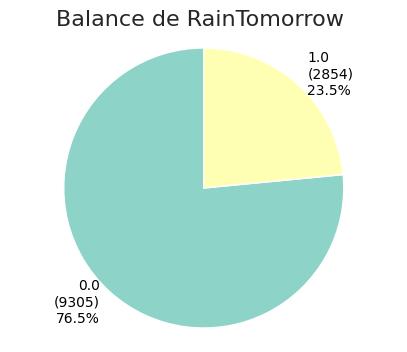

In [ ]:
def graficar_proporcion_datos(df, column):
    value_counts = column.value_counts() # cantidad de valores de cada clase

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 4))

    # controlar si la categoria es parte del dataframe, o una Serie aparte
    if isinstance(column, pd.Series):
        wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.5, colors=sns.color_palette('Set3'))
        plt.title(f'Balance de {column.name} ', fontsize=16)
    else:
        wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.5, colors=sns.color_palette('Set3'))
        plt.title(f'Balance de {column} ', fontsize=16)

    plt.axis('equal')

    # Añadir la cantidad de registros en cada clase
    for text, autotext, label in zip(texts, autotexts, value_counts.index):
        text.set_text(f'{label}\n({value_counts[label]})\n{round(value_counts[label]/df.shape[0], 3)*100}%')
        text.set_fontsize(10)
        text.set_color('black')

        autotext.set_text('')
        autotext.set_fontsize(8)
        autotext.set_color('white')

    plt.show()

graficar_proporcion_datos(X_train_standar, y_train_clasif)


Como el volumen del dataset es relativamente grande y el desbalanceo es grande, un metodo como oversampling para el balanceo de clases generaria cientos de registros sisnteticos al dataset. Esto podria incluir ruido a los modelos con datos falsos.

Por lo que intentamos primeramente un enfoque mas simple, de submuestrear la clase mayoritaria, reducuiendo el volumen de datos, a coste de balancear las clases.

En este caso, para no eliminar registros aleatoreamente, se utiliza un modelo que su funcion es eliminar registros de la clase mayoritaria, pero solo aquellos que se consideren valores atipicos. De esta manera podemos reducir simultaneamente la influencia de valores atipicos y del desbalnceo de clases.

In [ ]:
def undersample_remove_outliers(X, y_reg, y_clsif,  target_ratio=0.4):
    # Encuentra los índices de la clase mayoritaria
    majority_indices = np.where(y_clsif == 0.0)[0]

    # Encuentra los valores atípicos en la clase mayoritaria utilizando Isolation Forest
    isolation_forest = IsolationForest(contamination=target_ratio,  random_state=42)
    is_outlier = isolation_forest.fit_predict(X.iloc[majority_indices])

    # Encuentra los índices de los registros que no son atípicos
    non_outlier_indices = majority_indices[is_outlier == 1]

    # Combina los índices de la clase mayoritaria con la clase minoritaria
    indices_combined = np.concatenate([non_outlier_indices, np.where(y_clsif == 1.0)[0]])

    # Devuelve los conjuntos de datos undersampleados
    return X.iloc[indices_combined], y_reg.iloc[indices_combined], y_clsif.iloc[indices_combined]

# Realizar undersampling eliminando outliers para obtener 60% clase 0.0 y 50% clase 1.0
X_train_under, y_train_under, y_train_clasif_under = undersample_remove_outliers(X_train_standar, y_train, y_train_clasif, target_ratio=0.5)

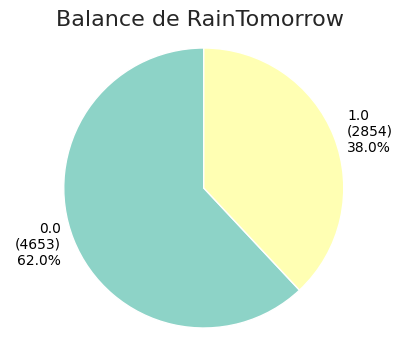

In [ ]:
# Ejemplo de uso
graficar_proporcion_datos(X_train_under, y_train_clasif_under)

Notamos que ahora la variable objetivo esta mas balanceada (aunque no perfectamente), pero a costa de gran perdida de informacion real util.

In [ ]:
base_model_clasification(X_train_under, X_test_standar, y_train_clasif_under, y_test_clasif)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainTomorrow
1,0.859074,-0.375347,-0.210494,-0.258374,-1.342178,0.722199,-0.719797,-0.012235,-0.051979,-0.005046,...,0.328183,0.300657,-1.40452,-1.446837,-0.298829,-0.060084,0.456489,0.445567,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.762,0.745
1,Precision,"[0.733, 0.893]","[0.832, 0.447]"
2,Recall,"[0.969, 0.425]","[0.838, 0.436]"
3,F1 Score,0.576,0.441


El modelo base de clasificacion ha mejorado sus metricas, pero aniade un gran desbalance, esta vez en el modelo como tal en su forma de entrenamiento.

Notamos que se genera el fenomeno de sobreajuste en training.

In [ ]:
base_linear_regression(X_train_under, X_test_standar, y_train_under, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainfallTomorrow
1,0.859074,-0.375347,-0.210494,-0.258374,-1.342178,0.722199,-0.719797,-0.012235,-0.051979,-0.005046,...,0.328183,0.300657,-1.40452,-1.446837,-0.298829,-0.060084,0.456489,0.445567,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,7.556748



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.301,7.515
1,Test,0.212,6.961


Lo mismo ocurre para el modelo de regresion lineal base ya que ahora no posee los mismo datos para entrenamiento. Se generan sobreajustes considerables.

Por lo que podemos intentar el siguiente enfoque de balanceo de clases, que es mediante oversampling, para generar mas datos de las clases minoritaria sin perder datos originales, pero generando datos sintentticos.

In [ ]:
def oversample_smote(X, y_reg, y_clsif):
    # Combina variables objetivo y explicativas para aplicar SMOTE
    data_combined = pd.concat([X, y_clsif, y_reg], axis=1)
    categorical_features = X.columns.isin(data_combined.columns) # para no generar valores unicos que originalmente no existian

    # Aplica SMOTE para generar nuevos registros sintéticos
    smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_resampled, y_clsif_resampled = smotenc.fit_resample(data_combined.drop(['RainTomorrow'], axis=1), data_combined['RainTomorrow'])

    # Separa las variables objetivo oversampleadas
    y_reg_resampled = pd.Series(X_resampled['RainfallTomorrow'], name='RainfallTomorrow')
    y_clsif_resampled = pd.Series(y_clsif_resampled, name='RainTomorrow')

    # Elimina las columnas adicionales agregadas por SMOTE
    X_resampled = X_resampled.drop('RainfallTomorrow', axis=1)

    # Devuelve los conjuntos de datos oversampleados
    return X_resampled, y_reg_resampled, y_clsif_resampled

# Realizar oversampling con SMOTE para obtener 50% clase 0.0 y 50% clase 1.0
X_train_over, y_train_over, y_train_clasif_over = oversample_smote(X_train_standar, y_train, y_train_clasif)

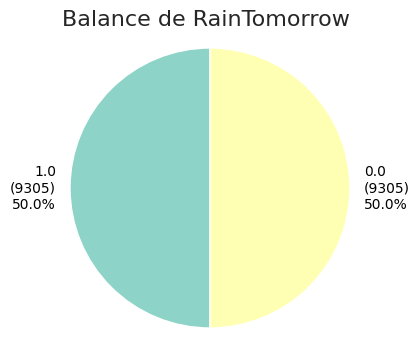

In [ ]:
graficar_proporcion_datos(X_train_over, y_train_clasif_over)

Notamos ahora que cada clase tiene una totalidad de 18mil registros cuando el dataframe original apenas tenia 12mil.

In [ ]:
base_model_clasification(X_train_over, X_test_standar, y_train_clasif_over, y_test_clasif)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainTomorrow
0,0.09651,-0.886705,-1.435649,-0.311066,-1.342178,-1.879434,1.932443,2.318473,1.576287,0.765944,...,0.600027,0.521979,1.168896,1.257202,-0.783879,-1.414602,0.37058,0.445567,0.0,1.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.619,0.745
1,Precision,"[0.584, 0.702]","[0.832, 0.447]"
2,Recall,"[0.825, 0.414]","[0.838, 0.436]"
3,F1 Score,0.521,0.441


In [ ]:
base_linear_regression(X_train_over, X_test_standar, y_train_over, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainfallTomorrow
0,0.09651,-0.886705,-1.435649,-0.311066,-1.342178,-1.879434,1.932443,2.318473,1.576287,0.765944,...,0.600027,0.521979,1.168896,1.257202,-0.783879,-1.414602,0.37058,0.445567,0.0,1.2



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,8.106981



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.251,8.509
1,Test,0.207,6.985


Notamos con este enfoque nuevamente presencia no despreciable de desbalanceo del modelo, generando overfitting en su entrenamiento.

Podemos probar otro metodo de diferente de unidersampling, ya que los valores que considera atipicos en realidad pueden resultar explicativos para los modelos.

Por lo que utilizaremos en este caso un metodo random de submuestreo para quitar valores de la calse mayoritaria.

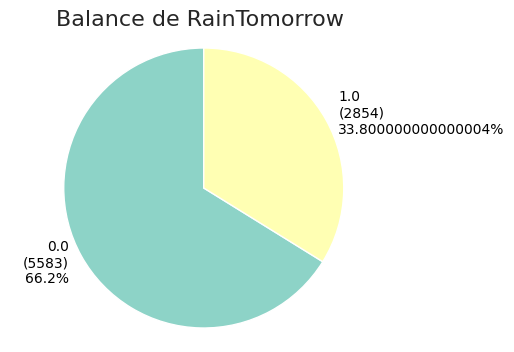

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainfallTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.776037,...,0.423328,0.660305,0.433635,-1.060546,0.599413,0.094228,-0.975327,-1.455921,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,5.619227



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.248,7.408
1,Test,0.231,6.877


In [ ]:
def undersample_random(X, y_reg, y_clsif, majority_class_size):
    # Combina variables objetivo y explicativas
    data_combined = pd.concat([X, y_clsif, y_reg], axis=1)

    # Determina la cantidad de instancias de la clase mayoritaria
    majority_class_count = int(majority_class_size * len(data_combined[y_clsif == 0]))

    # Aplica Random Undersampling para reducir la cantidad de instancias de la clase mayoritaria
    rus = RandomUnderSampler(sampling_strategy={0: majority_class_count, 1: len(data_combined[y_clsif == 1])}, random_state=42)
    X_resampled, y_clsif_resampled = rus.fit_resample(data_combined.drop(['RainTomorrow'], axis=1), data_combined['RainTomorrow'])

    # Separa las variables objetivo undersampleadas
    y_reg_resampled = pd.Series(X_resampled['RainfallTomorrow'], name='RainfallTomorrow')
    y_clsif_resampled = pd.Series(y_clsif_resampled, name='RainTomorrow')

    # Elimina las columnas adicionales agregadas por Random Undersampling
    X_resampled = X_resampled.drop('RainfallTomorrow', axis=1)

    # Devuelve los conjuntos de datos undersampleados
    return X_resampled, y_reg_resampled, y_clsif_resampled

# Realizar undersampling con Random Undersampling para obtener 60% clase 0.0 y 40% clase 1.0
X_train_under_rand, y_train_under_rand, y_train_clasif_under_rand = undersample_random(X_train_standar, y_train, y_train_clasif, 0.60)
graficar_proporcion_datos(X_train_under_rand, y_train_clasif_under_rand)
base_linear_regression(X_train_under_rand, X_test_standar, y_train_under_rand, y_test)

In [ ]:
base_model_clasification(X_train_under_rand, X_test_standar, y_train_clasif_under_rand, y_test_clasif)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.776037,...,0.423328,0.660305,0.433635,-1.060546,0.599413,0.094228,-0.975327,-1.455921,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.685,0.745
1,Precision,"[0.736, 0.544]","[0.832, 0.447]"
2,Recall,"[0.818, 0.425]","[0.838, 0.436]"
3,F1 Score,0.477,0.441


Notamos una buena respuesta, ya que la brecha entre las metricas de train y test ha disminuido, y se estabilizan en un punto medio que resulta en un mejora ante el dataset desbalanceado. Pero no podemos balancear perfectamente ya que la brecha se abre nuevamente.

Por lo tanto, el conjunto balanceado siguiente se arma con una combinacion de las tecnicas de submuestro  y sobremuestreo:
- Se eliminan de forma aleatoria valores de clase mayoritaria hasta dejar una proporcion de 60%/40%.
- Se generan registros sinteticos para la clase minoritaria hasta lograr un balance de 50%/50%.

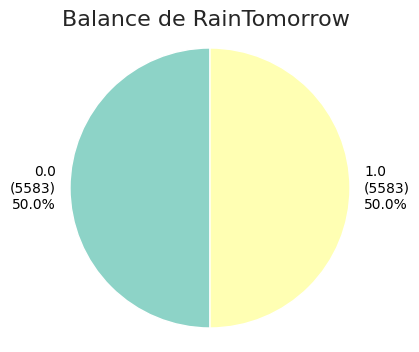

In [ ]:
# se prueban disitntos metodos de undersmapling, el insolator no funciona mejor
# X_train_under_out, y_train_under_out, y_train_clasif_under_out = undersample_remove_outliers(X_train_standar, y_train, y_train_clasif, target_ratio=0.1)
X_train_under_rand, y_train_under_rand, y_train_clasif_under_rand = undersample_random(X_train_standar, y_train, y_train_clasif, 0.6)
X_train_under_over, y_train_under_over, y_train_clasif_under_over = oversample_smote(X_train_under_rand, y_train_under_rand, y_train_clasif_under_rand)

graficar_proporcion_datos(X_train_under_over, y_train_clasif_under_over)

In [ ]:
base_linear_regression(X_train_under_over, X_test_standar, y_train_under_over, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainfallTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.776037,...,0.423328,0.660305,0.433635,-1.060546,0.599413,0.094228,-0.975327,-1.455921,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,7.667964



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.244,8.296
1,Test,0.212,6.963


In [ ]:
base_model_clasification(X_train_under_over, X_test_standar, y_train_clasif_under_over, y_test_clasif)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,RainTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.776037,...,0.423328,0.660305,0.433635,-1.060546,0.599413,0.094228,-0.975327,-1.455921,0.0,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,1.0,1.0



Metricas de validacion: 


,Metric,Train,Test
0,Accuracy,0.621,0.745
1,Precision,"[0.587, 0.7]","[0.832, 0.447]"
2,Recall,"[0.818, 0.425]","[0.838, 0.436]"
3,F1 Score,0.529,0.441


Notamos que este segundo paso en realidad no resulta favorable. Por lo tanto, como decicion final, nos quedamos con el el dataset que ha quedado balanceado a medias, donde nos quedan las clases con proporciones de datos de 60%/30%, debido a que las metricas demuestran mejores rendimeintos para este caso.

Mas tarde, cuando se armen modelos de clasificacion mas robustos, se retomara el enfoque de desbalanceo de clases, pero intentando condicionar los pesos que le asigna a cada una directamente en su forma de entramiento.


### Selección de características

Esta seccion es solo experimental. La idea es probar que tantas variables son realmente necesarias para que el modelo pueda explicar los datos.

Una tecnica de reduccion de dimensionalidad lineal como lo es el analisis de componentes principales puede ayudarnos a reducir las variables explicativas a menores dimensiones, ya que en escencia explican lo mismo.


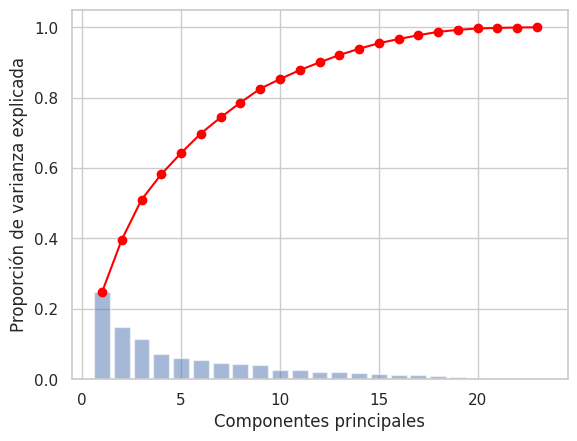

In [ ]:
#--- Obtencion de los componentes ---#
pca = PCA()

X_train_reduced = pca.fit_transform(X_train_under_rand)
X_train_reduced = pd.DataFrame(data=X_train_reduced, columns=[f"PC{i+1}" for i, _ in enumerate(X_train_under_rand.columns)]) # genera un df de las componentes


#--- Explicabilidad de los componentes ---#

varianza = np.cumsum(pca.explained_variance_ratio_)

acum = pd.DataFrame({"Component": X_train_reduced.columns,
                     "EigenValues": pca.explained_variance_,
                     "PropVar": pca.explained_variance_ratio_,
                     "VarAcum": varianza}) # aca interesa la varianza acumulada, que se asemeja al porcentaje de explicabilidad de los datos


# #--- grafico de explicabilidad ---#

plt.bar(range(1, 24), pca.explained_variance_ratio_, alpha=0.5, align="center")
plt.plot(range(1, 24), varianza, marker="o" ,color="red")
plt.ylabel("Proporción de varianza explicada")
plt.xlabel("Componentes principales")
plt.show()

Este grafico nos permite visualizar que el dataset puede reducirse a 10 o 15 variables sin perder gran parte de la informacion del dataset, ya que no presenta meyoria significativa si incluimos mas dimensiones reducidas al analisis.

Pero probemos lo siguiente:  En lugar de reemplar todo el conjunto de datos por estos componentes que explican lo mismo, pero son menos interpretables, que tanto mejora el modelo base si incluimos componentes con alta explicabilidad como columnas extras al dataframe original? cuantos componentes necesitamos que logren mejoras significativas en el rendimiento del modelo?

In [ ]:
X_test_reduced = pca.transform(X_test_standar)
X_test_reduced = pd.DataFrame(data=X_test_reduced, columns=[f"PC{i+1}" for i, _ in enumerate(X_test_standar.columns)]) # genera un df de las componentes

# unimcos al dataset original los primeros dos componenets mas explicativos
X_train_reduced = X_train_reduced[[f"PC{i}" for i in range(1, 2)]] # consideramos solo el primre compoennte
X_test_reduced = X_test_reduced[[f"PC{i}" for i in range(1, 2)]]

In [ ]:
X_train_with_pca = pd.concat([X_train_under_rand, X_train_reduced], axis=1)
X_test_with_pca = pd.concat([X_test_standar, X_test_reduced], axis=1)

base_linear_regression(X_train_with_pca, X_test_with_pca, y_train_under_rand, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Season,RainToday,PC1,RainfallTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.776037,...,0.660305,0.433635,-1.060546,0.599413,0.094228,-0.975327,-1.455921,0.0,0.827179,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,5.619227



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.248,7.408
1,Test,0.231,6.877


In [ ]:
# Guardar modelos
joblib.dump(pca, 'pca_model.joblib')

['pca_model.joblib']

Dejaremos solo el primer componente conectado de mayor explicabilidad como columna extra para el dataset. Si bien el modelo base no presenta mejora, esto nos da paso a poder remover variables que el componente puede reducir, y ayudar a los modelos para que esta variable aporte a la explicabilidad del modelo.

Tambien se crean nuevas caracteristicas de forma manual para maximizar la explicabilidad de la varible objetivo. Notamos que estas variables formadas mediante prueba y error dan mejores resultados para el modelo. Tambien se elimnan variables que por si solas no aportan nada a las metricas de validacion con el din de reducir la cantidad de dimensiones del dataset.

In [ ]:
def crear_nuevas_caracteristicas(df):
    df_copy = df.copy()

    df_copy['Humidity_Index'] = df_copy['Humidity9am'] * df_copy['Humidity3pm'] # indice general de humedad
    df_copy['Evaporation_Index'] = df_copy['Sunshine'] * df_copy['Evaporation'] # relacion de como se evapora respecto a la cantidad de horas de sol
    df_copy['Wind_Index'] = df_copy['WindGustDir'] * df_copy['WindGustSpeed'] # obtener la intesidad y direccion del viento combinadas
    df_copy['Light_Index'] = df_copy['Sunshine'] * ((df_copy['MaxTemp'] + df_copy['MinTemp'])/2) # indice de temperatura respecto a la cantidad de sol
    df_copy['Pressure_Index'] = df_copy['Pressure3pm'] * df_copy['Pressure9am'] # relacion general de presion atmosferica
    df_copy['Rainfall_Index'] = df_copy['Rainfall'] * df_copy['Sunshine'] # relacion en cantidad de lluvia con respecto a la cantidad de horas de sol
    df_copy.drop(['Season', 'WindDir3pm', 'WindSpeed9am', 'Humidity9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday'], axis=1, inplace=True) # eliminacion de variables que no aportan al modelo

    return df_copy

X_train_features = crear_nuevas_caracteristicas(X_train_with_pca)
X_test_features = crear_nuevas_caracteristicas(X_test_with_pca)

In [ ]:
base_linear_regression(X_train_features, X_test_features, y_train_under_rand, y_test)

Muestra conjunto de entrenamiento: 


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindSpeed3pm,...,Cloud9am,Month,PC1,Humidity_Index,Evaporation_Index,Wind_Index,Light_Index,Pressure_Index,Rainfall_Index,RainfallTomorrow
0,0.859074,0.528053,-0.028376,-0.311066,0.800003,-0.055608,-1.259834,-0.971939,-1.284625,-0.508854,...,0.433635,-0.975327,0.827179,0.055981,-0.044487,1.224482,-0.013893,0.279526,0.017298,0.0



Muestra prediccion: 


,Valor Real,Prediccion
0,8.8,7.081591



Metricas de validacion: 


,Set,R2,RMSE
0,Train,0.279,7.257
1,Test,0.271,6.696


De este analisis encontramos reduccir de dimencionalidad de variables no explicativas que no tiene impacto positivo en las metricas, sino que las mantiene tal como antes. Tambien se han agregado nuevas columnas que resultan en impactos positivos para el modelo ya que resultan explicar la variable objetivo con mayor precision, y que tambien ayudan a cerrar levemente la brecha de desbalanceo del modelo para no causar sobreajustes significativos.

### Conjuntos finales

Estos son los conjuntos de datos finales que han sido tranformados para optimizar la explicabilidad de las variables objetivo.

In [ ]:
# Datos de entrada
X_train_final = X_train_features.copy()
X_test_final = X_test_features.copy()

# y de regresión
y_train_regressor_final = y_train_under_rand.copy()
y_test_regressor_final = y_test.copy()

# y de clasificación
y_train_clasif_final = y_train_clasif_under_rand.copy()
y_test_clasif_final = y_test_clasif.copy()

# **Análisis Predictivo - Regresión**

Una vez que el conjunto de datos fue optimizado para que los modelos de regression lineal puedan interpretar de mejor manera las variables explicativas del conjunto, y que entendemos que hay variables con mas importancia que otras para tomar en cuenta a la hora de hacer una prediccion de la cantidad de lluvia, podemos realizar el siguiente analsis de predicciones.


### Visualización de modelos de regresión


Vamos a definir de manera conjunta todos los modelos lineales de interes.

Todos ellos son los brindados durante el cursado de la asignatura.
Cada modelo tiene parametros que no comunes entre si. Se elijen rangos de parametros para que cada modelo tenga la posibilidad de usarlo con distintos valores.

La siguiente funcion tomara un modelo como argumento. El modelo puede contener variedad de hiperparametros. Se entrena el modelo con el conjunto de datos curado, y de imprimen sus metricas en entrenamiento y validacion para comprobar el balance. Ademas se imprime un grafico con tres figuras que ayudan a comprender los residuos de las predicciones para enteder si el modelo tiende a sobreestimar o subestimar las predicciones.

In [ ]:
def train_and_evaluate(model):
    # Entrenar el modelo
    model.fit(X_train_final, y_train_regressor_final)

    # Predecir los valores para los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)

    # Calcular las métricas para los conjuntos de entrenamiento y prueba
    metrics_train = {
        'MSE': mean_squared_error(y_train_regressor_final, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train_regressor_final, y_train_pred)),
        'MAE': mean_absolute_error(y_train_regressor_final, y_train_pred),
        'R2': r2_score(y_train_regressor_final, y_train_pred)
    }
    metrics_test = {
        'MSE': mean_squared_error(y_test_regressor_final, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_regressor_final, y_test_pred)),
        'MAE': mean_absolute_error(y_test_regressor_final, y_test_pred),
        'R2': r2_score(y_test_regressor_final, y_test_pred)
    }

    # Imprimir el nombre del modelo y sus hiperparámetros
    print(f"{model.__class__.__name__} ({model.get_params()})")

    # Crear un DataFrame con las métricas y mostrarlo
    df_metrics = pd.DataFrame({'Train': metrics_train, 'Test': metrics_test})
    display(df_metrics)

    # Generar los gráficos de residuos y ajuste
    fig = plt.figure(figsize=(10, 5))
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 3), (0, 2))
    ax2 = plt.subplot2grid((2, 3), (1, 2))

    # diferencia entre los valores reales y los predichos
    residuos = y_test - y_test_pred

    ax0.scatter(y_test, y_test_pred, color='lightgray', alpha=0.75, edgecolor="black")
    ax0.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax0.set_xlabel("Observaciones reales")
    ax0.set_ylabel("Predicciones")
    ax0.set_title(f"Predicciones del modelo {model.__class__.__name__}")

    ax1.hist(residuos, bins=30, color='lightgray')
    ax1.set_title(f"Histograma de residuos")

    ax2.scatter(y_test_pred, residuos, color='lightgray', alpha=0.4, edgecolors='gray')
    ax2.axhline(y=residuos.mean(), color='black', linestyle='--')
    ax2.set_xlabel("Predicciones")
    ax2.set_ylabel("Residuos")
    ax2.set_title(f"Distribución de residuos")

    plt.tight_layout()
    plt.show()

    return df_metrics


In [ ]:
# Crear los widgets para los modelos y sus rangos hiperparámetros
model_widget = widgets.Dropdown(options=['LinearRegression', 'SGDRegressor', 'LassoCV', 'RidgeCV', 'ElasticNetCV'], description='Model:')
fit_intercept_widget = widgets.Checkbox(value=False, description='Fit Intercept')
max_iter_widget = widgets.IntSlider(min=10000, max=100000, step=10000, description='Max Iterations:')
alpha_widget = widgets.FloatSlider(min=0.001, max=1.0, step=0.01, description='Alpha:')
penalty_widget = widgets.Dropdown(options=['l1', 'l2', 'elasticnet', 'none'], description='Penalty:')
alphas_widget = widgets.SelectMultiple(options=[0.01, 0.1, 1.0, 10.0], description='Alphas:')
cv_widget = widgets.IntSlider(min=1, max=10, step=1, description='CV:')
l1_ratio_widget = widgets.FloatSlider(min=0.1, max=1.0, step=0.1, description='L1 Ratio:')

# Crear un botón para entrenar y evaluar el modelo
button = widgets.Button(description="Train and Evaluate")
out = widgets.Output()

# Crear un contenedor para los widgets de hiperparámetros
param_widgets = widgets.VBox([])

# Función para manejar el cambio de modelo y sus parametros
def on_model_change(change):
    if change['new'] == 'LinearRegression':
        param_widgets.children = [fit_intercept_widget]
    elif change['new'] == 'SGDRegressor':
        param_widgets.children = [max_iter_widget, alpha_widget, penalty_widget]
    elif change['new'] in ['LassoCV', 'RidgeCV']:
        param_widgets.children = [alphas_widget, cv_widget]
    elif change['new'] == 'ElasticNetCV':
        param_widgets.children = [alphas_widget, l1_ratio_widget, cv_widget]

# Conectar el evento de cambio de modelo a la función
model_widget.observe(on_model_change, names='value')

# Función para manejar el evento del botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Crear el modelo con los hiperparámetros seleccionados
    if model_widget.value == 'LinearRegression':
        model = LinearRegression(fit_intercept=fit_intercept_widget.value)
    elif model_widget.value == 'SGDRegressor':
        model = SGDRegressor(max_iter=max_iter_widget.value, alpha=alpha_widget.value, penalty=penalty_widget.value)
    elif model_widget.value == 'LassoCV':
        model = LassoCV(alphas=list(alphas_widget.value), cv=cv_widget.value)
    elif model_widget.value == 'RidgeCV':
        model = RidgeCV(alphas=list(alphas_widget.value), cv=cv_widget.value)
    elif model_widget.value == 'ElasticNetCV':
        model = ElasticNetCV(alphas=list(alphas_widget.value), l1_ratio=l1_ratio_widget.value, cv=cv_widget.value)

    # entrena y evalua el modelo elejido
    with out:
        # Entrenar y evaluar el modelo
        train_and_evaluate(model)

# Conectar el evento del botón a la función
button.on_click(on_button_clicked)

# Mostrar los widgets
display(model_widget, param_widgets, button, out)


Dropdown(description='Model:', options=('LinearRegression', 'SGDRegressor', 'LassoCV', 'RidgeCV', 'ElasticNetC…

VBox()

Button(description='Train and Evaluate', style=ButtonStyle())

Output()

Se pueden probar diferentes modelos y parametros. Pero en general notamos en todos los casos que los modelo tienden a subestimar.

Esto lo notamos debido a que los valores en la figura de la izquierda estan mayormente por debajo del modelo ideal. La linea de puntos diagonal representa un modelo ideal donde todas las predicciones coinciden con los valores reales.

Pero en nuestro caso notamos que para valores reales mas altos de cantidad de lluvia, nuestros modelos predicen valores mucho mas bajos de lo que en realidad deberian ser.

Esto mismo lo podemos notar en los graficos de la derecha, que representan la distribucion de los residuos. Notamos que mayormente son distribuciones que concentran bajos niveles de errores para la mayoria de datos. Pero que hay residuos que idealmente deberian ser 0, que en realidad son mucho mas altos.

### Optimización manual de hiperpárametros

Se pretende generar un dataset unico que contenga las distintas metricas de los modelos con combinaciones de hiperparametros con el fin de visualizar las evolucion de los modelos, y con el fin de encontrar a que modelo le pertenecen las mejores metricas de validacion.

In [ ]:
def evaluate(model):
    # Entrenar el modelo
    model.fit(X_train_final, y_train_regressor_final)

    # Predecir los valores para los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)

    # Calcular las métricas para los conjuntos de entrenamiento y prueba
    metrics_train = {
        'MSE': mean_squared_error(y_train_regressor_final, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train_regressor_final, y_train_pred)),
        'MAE': mean_absolute_error(y_train_regressor_final, y_train_pred),
        'R2': r2_score(y_train_regressor_final, y_train_pred)
    }
    metrics_test = {
        'MSE': mean_squared_error(y_test_regressor_final, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_regressor_final, y_test_pred)),
        'MAE': mean_absolute_error(y_test_regressor_final, y_test_pred),
        'R2': r2_score(y_test_regressor_final, y_test_pred)
    }

    # Crear un DataFrame con las métricas y mostrarlo
    df_metrics = pd.DataFrame({'Train': metrics_train, 'Test': metrics_test})

    return df_metrics


In [ ]:
# Definir los rangos de los parámetros
param_ranges = {
    'LinearRegression': {
        'fit_intercept': [True, False]
    },
    'SGDRegressor': {
        'max_iter': list(range(10000, 100001, 10000)),
        'alpha': [i / 100 for i in range(1, 101, 10)],
        'penalty': ['l1', 'l2', 'elasticnet', None]
    },
    'LassoCV': {
        'alphas': [[0.01, 0.1, 1.0, 10.0]],
        'cv': list(range(2, 11))
    },
    'RidgeCV': {
        'alphas': [[0.01, 0.1, 1.0, 10.0]],
        'cv': list(range(2, 11))
    },
    'ElasticNetCV': {
        'alphas': [[0.01, 0.1, 1.0]],
        'l1_ratio': [i / 10 for i in range(1, 11)],
        'cv': list(range(2, 11))
    }
}

model_metrics = {}

# Iterar sobre todos los modelos
for model_name, params_dict in param_ranges.items():
    # Crear un DataFrame vacío para almacenar los resultados
    results = pd.DataFrame()

    # Iterar sobre todas las combinaciones de parámetros
    for params in tqdm.tqdm(product(*params_dict.values()), total=len(list(product(*params_dict.values())))):
        params = dict(zip(params_dict.keys(), params))

        # Crear el modelo con los parámetros actuales
        if model_name == 'LinearRegression':
            model = LinearRegression(**params)
        elif model_name == 'SGDRegressor':
            model = SGDRegressor(**params)
        elif model_name == 'LassoCV':
            model = LassoCV(**params)
        elif model_name == 'RidgeCV':
            model = RidgeCV(**params)
        elif model_name == 'ElasticNetCV':
            model = ElasticNetCV(**params)

        metrics=evaluate(model)
        metrics_expandido = metrics.unstack().reset_index()
        metrics_expandido.columns = ['Set', 'Metric', 'Value']

        # Añadir los parámetros al DataFrame de métricas
        for param, value in params.items():
            if isinstance(value, list):
                value = str(value)
            metrics_expandido[param] = value

        # Añadir las métricas y los parámetros al DataFrame de resultados
        results = pd.concat([results, metrics_expandido])

    model_metrics[model.__class__.__name__] = results

100%|██████████| 90/90 [00:20<00:00,  4.30it/s]


Una vez entrenado cada variante de modelo y obtenido sus metricas de validación en ambos conjuntos, se reorganiza en un unico dataset toda esta informacion.

In [ ]:
# Crear un DataFrame vacío para almacenar los resultados
all_metrics = pd.DataFrame()

# Iterar sobre todos los modelos
for model_name, df in model_metrics.items():
    df['model'] = model_name
    all_metrics = pd.concat([all_metrics, df])

# Rellenar los valores faltantes con NaN
all_metrics.fillna(value=np.nan, inplace=True)

In [ ]:
# solo ordeno las columnas
all_metrics = all_metrics[['model', 'Set', 'Metric', 'Value', 'fit_intercept', 'max_iter', 'alpha', 'penalty', 'alphas', 'cv', 'l1_ratio']]

# remuevo el indice viejo
all_metrics.reset_index(inplace=True)
all_metrics.drop('index', axis=1, inplace=True)

In [ ]:
all_metrics.head(1)

,model,Set,Metric,Value,fit_intercept,max_iter,alpha,penalty,alphas,cv,l1_ratio
0,LinearRegression,Train,MSE,52.669641,True,NaN,NaN,NaN,NaN,NaN,NaN


Por ejemplo, para esta muestra tenemos el rendimeinto en training del modelo de Regression Lineal con el parametro fit_intercet activo.

### Análisis de mejores rendimientos

El mejor modelo no es el que tenga mayor o menor metrica de validacion. Si bien una metrica como R2 es evidente para entender que tan bueno es el ajuste del modelo con respecto a los datos, debemos considerar el balance del modelo. Es decir, si las metricas no son mayores o menores con respecto a su otro conjunto.

Para ello se agrega una nueva columna que define el ratio de R2, que es el cociente entre el R2 en train y el r2 en test.

Esto sera de ayuda para encontrar no solo el mejor valor para R2, si no tambien notar rapidamente si el modelo esta desbalanceado.

In [ ]:
ratio = all_metrics[(all_metrics['Metric'] == 'R2')].reset_index()

# Crear una nueva columna 'r2_ratio'
ratio['r2_ratio'] = 0.0  # Inicializar la columna con ceros
ratio['r2_ratio_diff'] = 0.0  # Inicializar la columna con ceros


# Iterar sobre las filas y calcular el r2_ratio
for i in range(0, len(ratio), 2):  # Incrementar de 2 en 2 ya que cada par de filas corresponde a Train y Test para el mismo modelo
    train_index = i
    test_index = i + 1

    # Calcular r2_ratio
    train_r2 = ratio.at[train_index, 'Value']
    test_r2 = ratio.at[test_index, 'Value']
    r2_ratio = train_r2 / test_r2
    r2_ratio_diff = abs(r2_ratio - 1)

    # Asignar el valor a la columna 'r2_ratio' para ambas filas
    ratio.at[train_index, 'r2_ratio'] = r2_ratio
    ratio.at[test_index, 'r2_ratio'] = r2_ratio
    ratio.at[train_index, 'r2_ratio_diff'] = r2_ratio_diff
    ratio.at[test_index, 'r2_ratio_diff'] = r2_ratio_diff


In [ ]:
# Ordenar las filas por R2 en Test y por la diferencia con 1 en r2_ratio
sorted_ratio = ratio.sort_values(by=['Value', 'r2_ratio_diff'], ascending=[False, True])

# Tomar el top 5 de mejor r2 balanceado
top_5_rows = sorted_ratio.head(5)
top_5_rows

,index,model,Set,Metric,Value,fit_intercept,max_iter,alpha,penalty,alphas,cv,l1_ratio,r2_ratio,r2_ratio_diff
0,3,LinearRegression,Train,R2,0.278558,True,NaN,NaN,NaN,NaN,NaN,NaN,1.027996,0.027996
822,3291,RidgeCV,Train,R2,0.278550,NaN,NaN,NaN,NaN,"[0.01, 0.1, 1.0, 10.0]",2.0,NaN,1.027520,0.027520
824,3299,RidgeCV,Train,R2,0.278550,NaN,NaN,NaN,NaN,"[0.01, 0.1, 1.0, 10.0]",3.0,NaN,1.027520,0.027520
826,3307,RidgeCV,Train,R2,0.278550,NaN,NaN,NaN,NaN,"[0.01, 0.1, 1.0, 10.0]",4.0,NaN,1.027520,0.027520
828,3315,RidgeCV,Train,R2,0.278550,NaN,NaN,NaN,NaN,"[0.01, 0.1, 1.0, 10.0]",5.0,NaN,1.027520,0.027520


Notamos superioridad del modelo de regression lineal simple con el parametro fit_intercet en False, ya que no solo posee el mas alto valor de R2 entre todos las variables de los demas modelos, sino tambien que el ratio de R2 es casi uno, por lo que el modelo esta balancedo en los conjuntos de train y test.

### Visualización de evolucion de métricas

Las siguientes funciones tienen intencion de generar graficos interactivos para la visualizacion de las metricas de validacion del modelo de regresion lineal para interpretar como afectan los diferentes valores para cada parametro a las predicciones del modelo.

In [ ]:
def find_x_column(tino_train):
    # Buscamos entre las columnas de parámetros
    param_columns = ['fit_intercept', 'max_iter', 'alpha', 'penalty', 'alphas', 'cv', 'l1_ratio']

    for column in param_columns:
        # Filtramos las no nulas y con al menos 2 valores únicos
        filtered_data = tino_train[column].dropna()
        unique_values = filtered_data.unique()

        if len(unique_values) >= 2:
            return column

    # Si no se encuentra ninguna columna que cumpla las condiciones, devuelve la primera columna de parámetros
    return param_columns[0]


def plot_evolution(fig, ax, tino_train, tino_test):

    column = find_x_column(tino_train)

    # Hacemos un gráfico para cada 'Set'
    if not tino_train['model'].iloc[0] == 'LinearRegression':
        ax.plot(tino_train[column], tino_train['Value'], label='Train')
        ax.plot(tino_test[column], tino_test['Value'], label='Test')

    else:
        if tino_train['Metric'].iloc[0] in ['RMSE', 'MSE', 'MAE']:
            ax.scatter(tino_train[column], tino_train['Value'], label='Train', s=tino_train['Value']*100)
            ax.scatter(tino_test[column], tino_test['Value'], label='Test', s=tino_train['Value']*100)
        else:
            ax.scatter(tino_train[column], tino_train['Value'], label='Train', s=tino_train['Value']*1000)
            ax.scatter(tino_test[column], tino_test['Value'], label='Test', s=tino_train['Value']*1000)

    # Añadimos una leyenda
    ax.legend()
    plt.xlabel(f'{column}')
    plt.ylabel(f"{tino_train['Metric'].iloc[0]}")  # Cambié las comillas exteriores a comillas dobles
    plt.title(f"{tino_train['model'].iloc[0]}")  # Cambié las comillas exteriores a comillas dobles

    return fig

In [ ]:
# Crear los widgets para cada parámetro
model_widget = widgets.Dropdown(value='SGDRegressor', options=['LinearRegression', 'SGDRegressor', 'LassoCV', 'RidgeCV', 'ElasticNetCV'], description='Modelo:')
metric_widget = widgets.Dropdown(options=['MSE', 'RMSE', 'MAE', 'R2'], description='Métrica:')
fit_intercept_widget = widgets.Checkbox(value=True, description='fit_intercept')
max_iter_widget = widgets.IntSlider(min=10000, max=100000, step=10000, description='max_iter')
alpha_widget = widgets.FloatSlider(min=0.01, max=1.0, step=0.01, description='alpha')
penalty_widget = widgets.Dropdown(options=['None', 'l1', 'l2', 'elasticnet'], description='penalty')
alphas_widget = widgets.Dropdown(options=['[0.01, 0.1, 1.0, 10.0]', '[0.01, 0.1, 1.0]'], description='alphas')
cv_widget = widgets.IntSlider(min=1, max=10, step=1, description='cv')
l1_ratio_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.1, description='l1_ratio')
x_column_widget = widgets.Dropdown(options=[], description='Eje x:')
out = widgets.Output()


# Función para manejar el cambio de modelo
def on_model_change(change):
    if change['new'] == 'LinearRegression':
        param_widgets.children = [fit_intercept_widget]
        x_column_widget.options = ['fit_intercept']
    elif change['new'] == 'SGDRegressor':
        param_widgets.children = [max_iter_widget, alpha_widget, penalty_widget]
        x_column_widget.options = ['max_iter', 'alpha']
    elif change['new'] in ['LassoCV', 'RidgeCV']:
        param_widgets.children = [alphas_widget, cv_widget]
        x_column_widget.options = ['cv']
    elif change['new'] == 'ElasticNetCV':
        param_widgets.children = [alphas_widget, l1_ratio_widget, cv_widget]
        x_column_widget.options = ['alphas', 'l1_ratio', 'cv']

# Conectar la función de cambio de modelo al widget de modelo
model_widget.observe(on_model_change, names='value')

# Botón para aplicar filtros y mostrar el DataFrame resultante
apply_button = widgets.Button(description="Aplicar Filtros")

# Función para manejar el clic del botón
def on_apply_button_click(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Obtener los valores seleccionados en los widgets
    selected_fit_intercept = fit_intercept_widget.value
    selected_max_iter = max_iter_widget.value
    selected_alpha = alpha_widget.value
    if penalty_widget.value == 'None':
        selected_penalty = np.nan
    else:
        selected_penalty = penalty_widget.value
    selected_alphas = alphas_widget.value
    selected_cv = cv_widget.value
    selected_l1_ratio = l1_ratio_widget.value
    selected_x_column = x_column_widget.value

   # Filtrar el DataFrame usando los valores seleccionados en los widgets
    tino = all_metrics[
        (all_metrics['model'] == model_widget.value) &
        (all_metrics['Metric'] == metric_widget.value) &
        ((all_metrics['fit_intercept'] == selected_fit_intercept) | (all_metrics['fit_intercept'].isna()) | (selected_x_column == 'fit_intercept')) &
        ((all_metrics['max_iter'] == selected_max_iter) | (all_metrics['max_iter'].isna()) | (selected_x_column == 'max_iter')) &
        ((all_metrics['alpha'] == selected_alpha) | (all_metrics['alpha'].isna()) | (selected_x_column == 'alpha')) &
        (((selected_penalty is np.nan) & all_metrics['penalty'].isna()) | ((selected_penalty is not np.nan) & (all_metrics['penalty'] == selected_penalty)) | (selected_x_column == 'penalty')) &
        ((all_metrics['alphas'] == selected_alphas) | (all_metrics['alphas'].isna()) | (selected_x_column == 'alphas')) &
        ((all_metrics['cv'] == selected_cv) | (all_metrics['cv'].isna()) | (selected_x_column == 'cv')) &
        ((all_metrics['l1_ratio'] == selected_l1_ratio) | (all_metrics['l1_ratio'].isna()) | (selected_x_column == 'l1_ratio'))
    ]

    # Separamos los datos por 'Set'
    tino_train = tino[tino['Set'] == 'Train']
    tino_test = tino[tino['Set'] == 'Test']

    # Creamos una figura y un eje
    fig, ax = plt.subplots()
    plot_evolution(fig, ax, tino_train, tino_test)

    with out:
        plt.show()


# Conectar la función de clic del botón al botón
apply_button.on_click(on_apply_button_click)

# Mostrar los widgets y el botón
display(model_widget, metric_widget, param_widgets, x_column_widget, apply_button, out)

Dropdown(description='Modelo:', index=1, options=('LinearRegression', 'SGDRegressor', 'LassoCV', 'RidgeCV', 'E…

Dropdown(description='Métrica:', options=('MSE', 'RMSE', 'MAE', 'R2'), value='MSE')

Dropdown(description='Eje x:', options=(), value=None)

Button(description='Aplicar Filtros', style=ButtonStyle())

Output()

Podemos notar la evolucion de las metricas de validacion de cada modelo en train y test para notar rapidamente como afectan los parametros en los modelos. Ademas nos permite ver rapidamente el balance del modelo. Es decir si sobreajusta o subajusta las predicciones, y en que momentos encuentra balances.

### Elección de modelo de regresión

Este sera el modelo final de regresion lineal para estimacion de cantidad de lluvia como modelo lineal debido a que ha demostrado mejor rendimiento a la hora de hacer predicciones.

In [ ]:
model_linear_final = LinearRegression(fit_intercept=True)
model_linear_final.fit(X_train_final, y_train_regressor_final)

LinearRegression()

### Explicabilidad

Presentamos un grafico de explicabilidad global de los valores shap de las variables del dataset usado para entrenar el modelo.

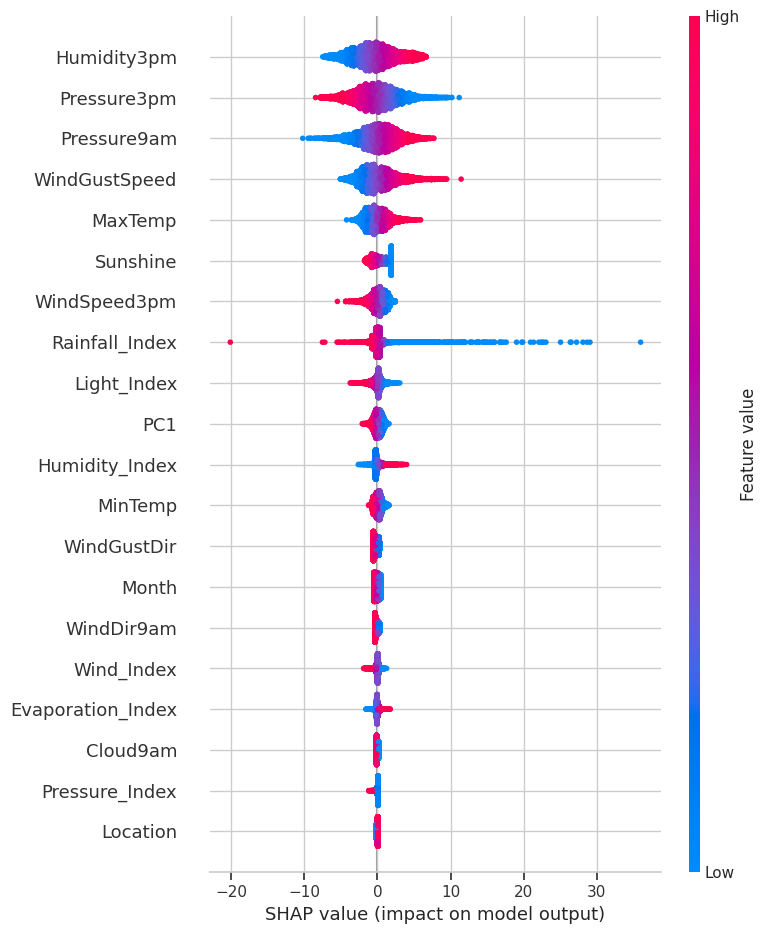

In [ ]:
# Crear el objeto explainer
explainer = shap.LinearExplainer(model_linear_final, X_train_final, feature_names=X_train_final.columns)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer(X_train_final)

# Crear un gráfico de resumen
shap.summary_plot(shap_values, X_train_final)

Notamos que hay variables mas explicativas que otras. Las variables meteorologicas como la humedad, la presion y la temperatura son de gran utilidad para explicar la cantidad de lluvia del dia siguiente. Es intuitivo que esto ocurra debido a que son variables que generalmente condicionan el estado de la lluvia de una region.

Por otro lado, notamos que variables agregadas como los indices resultan de utilidad para el modelo debido a que tienen un alto impacto para estimar nuevos valores.

Particularmente el indice de lluvia es de gran aporte debido a que conocer indices muy bajos de esta variable implica gran impacto a la hora de realizar predicciones.

En cambio, el primer componente principal que agregamos como variable explicativa resulto no ser de gran aporte, al contrario de lo que esperabamos, ya que esta variable teoricamente deberia explicar buena parte de las relaciones entre variables.

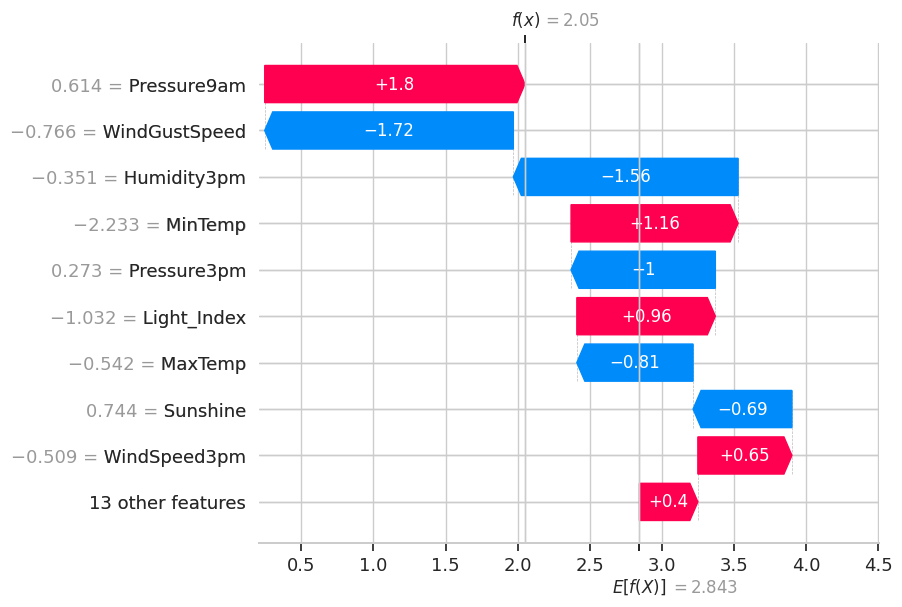

In [ ]:
index=100
model_linear_final.predict(X_train_final)[index] # filtramos un registro dado de los datos de validacion

shap_values = explainer(X_train_final) # explicabilidad de los datos de validacion

explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=X_train_final.columns)

shap.plots.waterfall(explanation)

Notamos para un registro en particular algo similar. Las variables originales en general mejoran o aumentan el valor de prediccion con buena intensidad, particularmente las variables metorilogicas que condicionan el clima.

Y nuevamente notamos que los indicies, en este caso el de luminosidad, aportan buena parte a las predicciones que realiza el modelo.

# **Análisis Predictivo - Clasificación**

Se explaran los hiperparametros y desempeños de los modelos para optimizar sus metricas de validacion a la hora de estimar la presencia de lluvia para el dia posterior a un registro.

### Comparación manual de hiperpárametros

El objetivo es poder comparar el rendimiento de los modelos de clasificacion cuando los parametros del mismo tiene diferentes combinaciones el la forma de interpretar las clases, metodos que usa para regularizar, o las iteriaciones que utiliza para converger.

Esta funcion tiene la intencion de tomar un dataset preprocesado y entrenar un modelo con los parametros indicados para retornar las metricas de valiacion tanto para Train como Test para cada clase de la variable objetivo. Ademas de los hiperparametros que se corresponden a esa metrica.

In [ ]:
def train_and_evaluate_model(params, X_train, y_train, X_test, y_test):
    # entrenamiento con los pararametros dados
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)

    # para validar train y test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracy para ambos sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # recall para ambos sets y clases
    train_recall = recall_score(y_train, y_train_pred, average=None)
    test_recall = recall_score(y_test, y_test_pred, average=None)

    # presicion para ambos sets y clases
    train_precision = precision_score(y_train, y_train_pred, average=None)
    test_precision = precision_score(y_test, y_test_pred, average=None)

    # f1 para ambos sets y clases
    train_f1 = f1_score(y_train, y_train_pred, average=None)
    test_f1 = f1_score(y_test, y_test_pred, average=None)

    # auc para ambos sets
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Crear diccionario con los resultados para el conjunto de entrenamiento
    train_results = {
        'set': 'Train',
        0.0: {'accuracy': train_accuracy, 'recall': train_recall[0], 'precision': train_precision[0], 'f1': train_f1[0], 'auc': train_auc},
        1.0: {'accuracy': train_accuracy, 'recall': train_recall[1], 'precision': train_precision[1], 'f1': train_f1[1], 'auc': train_auc}
    }

    # Crear diccionario con los resultados para el conjunto de prueba
    test_results = {
        'set': 'Test',
        0.0: {'accuracy': test_accuracy, 'recall': test_recall[0], 'precision': test_precision[0], 'f1': test_f1[0], 'auc': test_auc},
        1.0: {'accuracy': test_accuracy, 'recall': test_recall[1], 'precision': test_precision[1], 'f1': test_f1[1], 'auc': test_auc}
    }

    # Convertir los diccionarios a DataFrames
    train_df = pd.DataFrame(train_results).reset_index()
    test_df = pd.DataFrame(test_results).reset_index()

    result_clasif = pd.concat([train_df, test_df], axis=0)
    result_clasif.columns = ['metric', 'set', '0.0', '1.0']

    # añiado la configuracion de los hiperparametros
    result_clasif['penalty'] = params['penalty']
    result_clasif['C'] = params['C']
    result_clasif['class_weight'] = str(params['class_weight'])
    result_clasif['fit_intercept'] = params['fit_intercept']
    result_clasif['max_iter'] = params['max_iter']
    result_clasif['solver'] = params['solver']

    return result_clasif.sort_values(by='metric')

In [ ]:
# Ejemplo de hiperparámetros
params = {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

# Obtener el diccionario con los resultados
clasif_results = train_and_evaluate_model(params, X_train_final, y_train_clasif_final, X_test_final, y_test_clasif_final)
clasif_results

,metric,set,0.0,1.0,penalty,C,class_weight,fit_intercept,max_iter,solver
0,accuracy,Train,0.695389,0.695389,l1,0.001,balanced,True,100,liblinear
0,accuracy,Test,0.682566,0.682566,l1,0.001,balanced,True,100,liblinear
4,auc,Train,0.793603,0.793603,l1,0.001,balanced,True,100,liblinear
4,auc,Test,0.814295,0.814295,l1,0.001,balanced,True,100,liblinear
3,f1,Train,0.740352,0.631594,l1,0.001,balanced,True,100,liblinear
3,f1,Test,0.758448,0.537170,l1,0.001,balanced,True,100,liblinear
2,precision,Train,0.849131,0.534449,l1,0.001,balanced,True,100,liblinear
2,precision,Test,0.914303,0.404917,l1,0.001,balanced,True,100,liblinear
1,recall,Train,0.656278,0.771899,l1,0.001,balanced,True,100,liblinear
1,recall,Test,0.647990,0.797721,l1,0.001,balanced,True,100,liblinear


Este es el resultado obtenido por cada configuracion de modelo. Notamos que disponemos de todas las metricas de validacion para ambos conjunto, de cada uno las metricas de clase, segun corresponda.

La idea ahora es recopilar esta informacion de cada configuracion de modelo en un unico dataset para luego navegar y encontrar a que modelo le corresponden las mejores metricas de validacion.

In [ ]:
# Definir la rejilla de hiperparámetros
param_grid = {
    'penalty': [None, 'l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced', {0:1, 1:3}]
}

# Filtrar combinaciones inconsistentes entre solver y penalty
consistent_param_combinations = []

for params in ParameterGrid(param_grid):
    penalty = params['penalty']
    solver = params['solver']

    # Verificar si la combinación es consistente
    if (solver == 'lbfgs' and penalty in [None, 'l2']) or (solver == 'liblinear' and penalty in ['l1', 'l2']):
        consistent_param_combinations.append(params)

# Crear una lista de todas las combinaciones posibles consistentes
param_combinations = consistent_param_combinations
param_combinations[0] # ejemplo de combinacion

{'C': 0.01,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': None,
 'solver': 'lbfgs'}

In [ ]:
# Crear una lista para almacenar los resultados
results_list = []

# Iterar sobre todas las combinaciones de parámetros
for params in tqdm.tqdm(param_combinations, desc="Processing models"):
    # Llamar a la función y almacenar los resultados
    clasif_results = train_and_evaluate_model(params, X_train_final, y_train_clasif_final, X_test_final, y_test_clasif_final)

    # Añadir los resultados a la lista
    results_list.append(clasif_results)

Processing models: 100%|██████████| 192/192 [00:36<00:00,  5.30it/s]


In [ ]:
# Concatenar todos los DataFrames en uno solo
final_results = pd.concat(results_list, axis=0).reset_index()
final_results = final_results.drop('index', axis=1)
final_results.head(1)

,metric,set,0.0,1.0,penalty,C,class_weight,fit_intercept,max_iter,solver
0,accuracy,Train,0.77575,0.77575,None,0.01,balanced,True,100,lbfgs


### Visualiazación de modelos

El siguiente grafico tiene intencion de mostrar las tasas de aciertos del modelo de prueba. Los hiperparametros se pueden ajustar manualmente en esta celda para probar los diferentes resultados posibles.

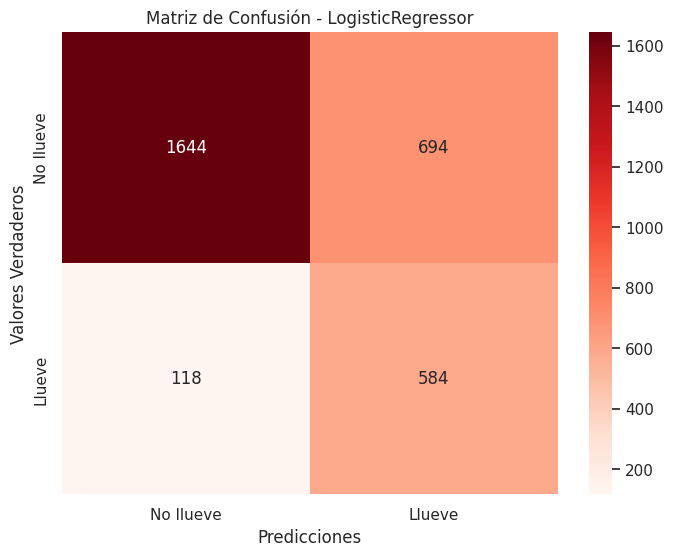

In [ ]:
def plot_conf_matrix(model, X_test, y_test, modelo_str):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No llueve', 'Llueve'], yticklabels=['No llueve', 'Llueve'])
    plt.title(f'Matriz de Confusión - {modelo_str}')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.show()

# guardamos la mejor configuracion de parametros
best_model_params = {
    'C' : 0.01,
    'class_weight' : {0.0: 1, 1.0: 3},
    'fit_intercept' : True,
    'max_iter' : 100,
    'solver' : 'lbfgs',
    'penalty' : 'l2'
}

# modelo formal de clasificacion
model_for_plot = LogisticRegression(**best_model_params)
model_for_plot.fit(X_train_final, y_train_clasif_final)
plot_conf_matrix(model_for_plot, X_test_final, y_test_clasif_final, 'LogisticRegressor')

Notamos tendencias de que el modelo acierta con certeza que no llueve cuando realmente no lluve el dia siguiente. Pero en cambio notamos para esta configuracion particular que el modelo tiende a equivocarse seguir al estimar que si llueve cuando en realidad no lo hace.

Esto puede deberse a cause del desbalanceo de los datos.

### Elección de modelo de clasificación


Podemos obtener del dataframe anterior que reune todas las metricas de todas las combinaciones de hiperarametros cuales son los parametros que mas optimizan las metricas de validacion. En este caso interesa obtener cuales son los mejores modelos de clasificacion que maximizan el area bajo la curva AUC, pero que a su minimizen el desbalance del modelo en entramiento y testing.

In [ ]:
# Supongamos que tu DataFrame se llama "final_results" y ya lo has filtrado para las métricas de AUC (test_metrics)
test_metrics = final_results[final_results['metric'] == 'auc'].reset_index()

# Crear una nueva columna 'auc_ratio'
test_metrics['auc_ratio'] = 0.0  # Inicializar la columna con ceros
test_metrics['auc_ratio_diff'] = 0.0  # Inicializar la columna con ceros

# Iterar sobre las filas y calcular el auc_ratio
for i in range(0, len(test_metrics), 2):  # Incrementar de 2 en 2 ya que cada par de filas corresponde a Train y Test para el mismo modelo
    train_index = i
    test_index = i + 1

    # Calcular auc_ratio
    train_auc = test_metrics.at[train_index, '1.0']
    test_auc = test_metrics.at[test_index, '1.0']
    auc_ratio = train_auc / test_auc
    auc_ratio_diff = abs(auc_ratio - 1)

    # Asignar el valor a la columna 'auc_ratio' para ambas filas
    test_metrics.at[train_index, 'auc_ratio'] = auc_ratio
    test_metrics.at[test_index, 'auc_ratio'] = auc_ratio
    test_metrics.at[train_index, 'auc_ratio_diff'] = auc_ratio_diff
    test_metrics.at[test_index, 'auc_ratio_diff'] = auc_ratio_diff

# Ordenar el DataFrame por AUC de Test y la diferencia de ratios
sorted_results = test_metrics.sort_values(by=['1.0', 'auc_ratio_diff'], ascending=[False, True])

# Mostrar los 5 mejores modelos
top_5_models = sorted_results.head(5)
top_5_models

,index,metric,set,0.0,1.0,penalty,C,class_weight,fit_intercept,max_iter,solver,auc_ratio,auc_ratio_diff
55,273,auc,Test,0.858564,0.858564,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs,0.984016,0.015984
63,313,auc,Test,0.858564,0.858564,l2,0.01,"{0: 1, 1: 3}",True,200,lbfgs,0.984016,0.015984
71,353,auc,Test,0.858564,0.858564,l2,0.01,"{0: 1, 1: 3}",True,300,lbfgs,0.984016,0.015984
79,393,auc,Test,0.858561,0.858561,l2,0.01,"{0: 1, 1: 3}",False,100,lbfgs,0.984024,0.015976
87,433,auc,Test,0.858561,0.858561,l2,0.01,"{0: 1, 1: 3}",False,200,lbfgs,0.984024,0.015976


Obtenemos un modelo que optimiza estas dos condiciones, y notamos por ejemplo, que es mejor balancear los pesos de las clases manualmente en lugar de usar el balance automatico por defecto del modelo.

In [ ]:
best_model_metrics = final_results[(final_results['C']==0.01)
                & (final_results['class_weight']=='{0: 1, 1: 3}')
                & (final_results['fit_intercept']==True)
                & (final_results['max_iter']==100)
                & (final_results['solver']=='lbfgs')
                & (final_results['penalty']=='l2')]

best_model_metrics

,metric,set,0.0,1.0,penalty,C,class_weight,fit_intercept,max_iter,solver
270,accuracy,Train,0.740073,0.740073,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
271,accuracy,Test,0.732895,0.732895,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
272,auc,Train,0.844841,0.844841,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
273,auc,Test,0.858564,0.858564,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
274,f1,Train,0.780239,0.681943,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
275,f1,Test,0.801951,0.589899,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
276,precision,Train,0.885578,0.581787,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
277,precision,Test,0.933031,0.456964,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
278,recall,Train,0.697295,0.823756,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs
279,recall,Test,0.703165,0.831909,l2,0.01,"{0: 1, 1: 3}",True,100,lbfgs


Este modelo sera exportado en un archivo como modelo final de clasificacion debido a que como se vera mas adelante en el proyecto, este es el modelo con mejores metricas de validacion para la prediccion de lluvia.

In [ ]:
# guardamos la mejor configuracion de parametros
best_model_params = {
    'C' : best_model_metrics.C.values[0],
    'class_weight' : {0.0: 1, 1.0: 3},
    'fit_intercept' : best_model_metrics.fit_intercept.values[0],
    'max_iter' : best_model_metrics.max_iter.values[0],
    'solver' : best_model_metrics.solver.values[0]
}

# modelo formal de clasificacion
best_logistic_model = LogisticRegression(**best_model_params)
best_logistic_model.fit(X_train_final, y_train_clasif_final)
joblib.dump(best_logistic_model, 'best_logistic_model.joblib')

['best_logistic_model.joblib']


### Explicabilidad

Podemos interpretar como el modelo de clasificacion toma de referencia la importnacia de las variables explicativas para realizar estimaciones de la variable binaria.

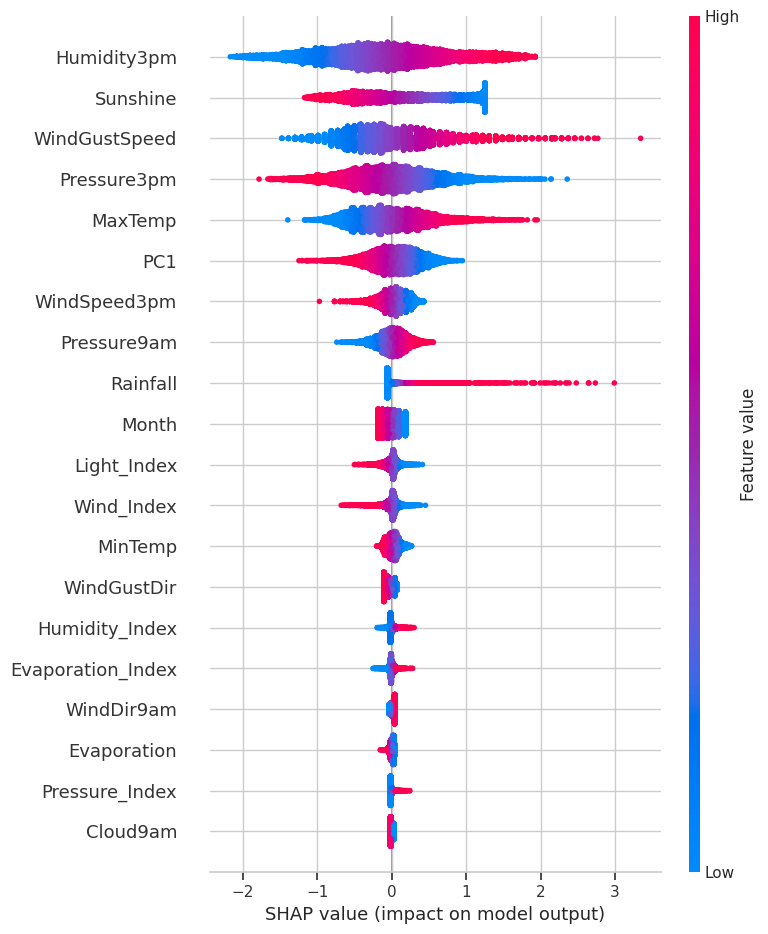

In [ ]:
# Crear el objeto explainer
explainer = shap.LinearExplainer(best_logistic_model, X_train_final, feature_names=X_train_final.columns)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer(X_train_final)

# Crear un gráfico de resumen
shap.summary_plot(shap_values, X_train_final)

En este caso notamos valores de shap altos en varias varibles. Esta vez el modelo determina que las variables originales que condicionan el clima de la region son altamente relevantes para explicar la variable objetivo.

Podemos notar por ejemplo, que velocidades del viento muy altas resultan de alto impacto para determinar la presencia de lluvia.

Caso contrario a la regresion lineal, las variables agregadas de indices metoreologicos en este modelo no son tan relevantes para explicar la variable. Pero por ejemplo, el primer componente principal si tiene buena presencia, resultando de utilidad para las futuras estimaciones.

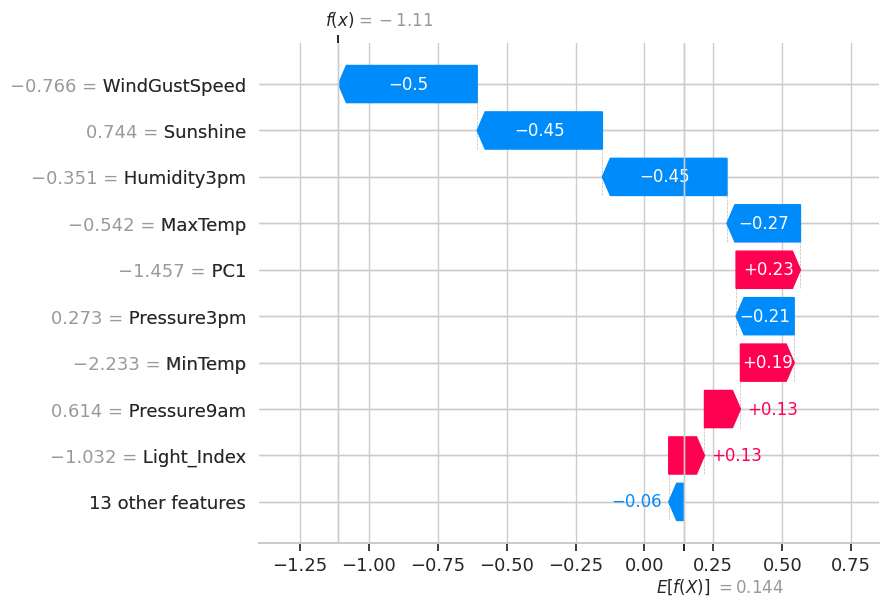

In [ ]:
index=100
best_logistic_model.predict(X_train_final)[index] # filtramos un registro dado de los datos de validacion

shap_values = explainer(X_train_final) # explicabilidad de los datos de validacion

explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=X_train_final.columns)

shap.plots.waterfall(explanation)

Las conclusiones son similares al grafico global para esta prediccion en particular. Ya que notamos que las variables como velocidades del viento, humedad, etc. resultan de utilidad para estimar el valor final de la prediccion. Mientras que PC1 mantiene buena presencia para lograr el valor final.

# **Analisis Predictivo - Enfoque Neuronal**

### Definición de modelo de regresión base

A continuación definiremos un modelo de regresión base basado en redes neuronales para poder tener métricas como parámetros para buscar mejores modelos.
Una vez definido lo entrenamos.

In [ ]:
def agregar_capa(model, n_neurons, activation):
  model.add(Dense(n_neurons, activation))


def create_model(X, optimizer='adam', activation='relu', n_layers_hidden=1, neurons=[10]):
  model = Sequential()
  model.add(Dense(X.shape[1], input_dim=X.shape[1], activation=activation))

  for i in range(n_layers_hidden):
    agregar_capa(model, neurons[i], activation)  # Agregamos la cantidad definida de capas ocultas

  model.add(Dense(1, activation='linear'))  # Capa de salida para regresión lineal

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
  return model


nn_regressor_model = create_model(X_train_final, 'adam', 'relu', 2, [10, 10])
nn_regressor_model.fit(X_train_final, y_train_regressor_final, epochs=10, batch_size=32, validation_data=(X_test_final, y_test_regressor_final), verbose=0)

Observamos sus métricas.

In [ ]:
def nn_model_regressor_metrics(model, X_train, X_test, y_train, y_test):

  y_pred_train = model.predict(X_train, verbose=0)
  y_pred_test = model.predict(X_test, verbose=0)

  mse_train = mean_squared_error(y_train, y_pred_train)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  r2_train = r2_score(y_train, y_pred_train)

  mse_test = mean_squared_error(y_test, y_pred_test)
  mae_test = mean_absolute_error(y_test, y_pred_test)
  r2_test = r2_score(y_test, y_pred_test)

  metrics_df = pd.DataFrame({
      'MSE_train': [mse_train],
      'MAE_train': [mae_train],
      'R2_train': [r2_train],
      'MSE_test': [mse_test],
      'MAE_test': [mae_test],
      'R2_test': [r2_test]
  })

  return metrics_df


nn_regressor_model_metrics_df = nn_model_regressor_metrics(nn_regressor_model, X_train_final, X_test_final, y_train_regressor_final, y_test_regressor_final)
nn_regressor_model_metrics_df

,MSE_train,MAE_train,R2_train,MSE_test,MAE_test,R2_test
0,48.228521,3.337142,0.33939,41.041339,2.937364,0.332656


Vemos que ya de base las métricas (por más que no sea un modelo óptimo) superan ampliamente a las métricas obtenidas anteriormente por los modelos de regresión lineal.

### Prueba de hiperparámetros para modelo de redes neuronales de regresión

Ahora procederemos a hacer una prueba de hiperparámetros para encontrar los óptimos.
Esta prueba se basa en encontrar al modelo que tenga el r2 más balanceado entre train y test.

In [ ]:
def hp_tuning_nn_regressor(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    n_units_layer = randint(4, 12)
    n_neurons = []

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', n_units_layer, n_units_layer) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        n_neurons.append(num_units)

    test_model = create_model(X_train_final, n_layers_hidden=num_layers, neurons=n_neurons)

    # Entrenamos el modelo
    test_model.fit(X_train_final, y_train_regressor_final, validation_data=(X_test_final, y_test_regressor_final), epochs=20, batch_size=32, verbose=0)

    # Se evalua el modelo
    score = nn_model_regressor_metrics(test_model, X_train_final, X_test_final, y_train_regressor_final, y_test_regressor_final)
    r2_diff = abs(score.R2_test.values[0] - score.R2_train.values[0]) # La diferencia entre ambos r2
    return r2_diff

# crear un estudio de Optuna
study_regressor_nn = optuna.create_study(direction='minimize')
study_regressor_nn.optimize(hp_tuning_nn_regressor, n_trials=25)

best_params_regressor_nn = study_regressor_nn.best_params
print("Mejores parámetros encontrados:", best_params_regressor_nn)

Mejores parámetros encontrados: {'num_layers': 1, 'n_units_layer_0': 5}


Lo testeamos.

In [ ]:
best_params_regressor_nn_model = {
    'n_layers_hidden': best_params_regressor_nn['num_layers'],
    'neurons': [best_params_regressor_nn[f'n_units_layer_{i}'] for i in range(best_params_regressor_nn['num_layers'])]
    }

best_nn_regressor_model = create_model(X_train_final, **best_params_regressor_nn_model)
best_nn_regressor_model.fit(X_train_final, y_train_regressor_final, epochs=20, verbose=0)

metrics_best_nn_regressor_model = nn_model_regressor_metrics(best_nn_regressor_model, X_train_final, X_test_final, y_train_regressor_final, y_test_regressor_final)
metrics_best_nn_regressor_model

,MSE_train,MAE_train,R2_train,MSE_test,MAE_test,R2_test
0,46.523757,3.098038,0.362741,40.528385,2.716394,0.340997


Vemos una mejoría de métricas pero no nos quedaremos solo con los números, iremos a detalles visualizando la mejoría.

### Visualización del desempeño del modelo de regresión

Observamos la comparación entre las métricas obtenidas por el modelo base y el mejor modelo

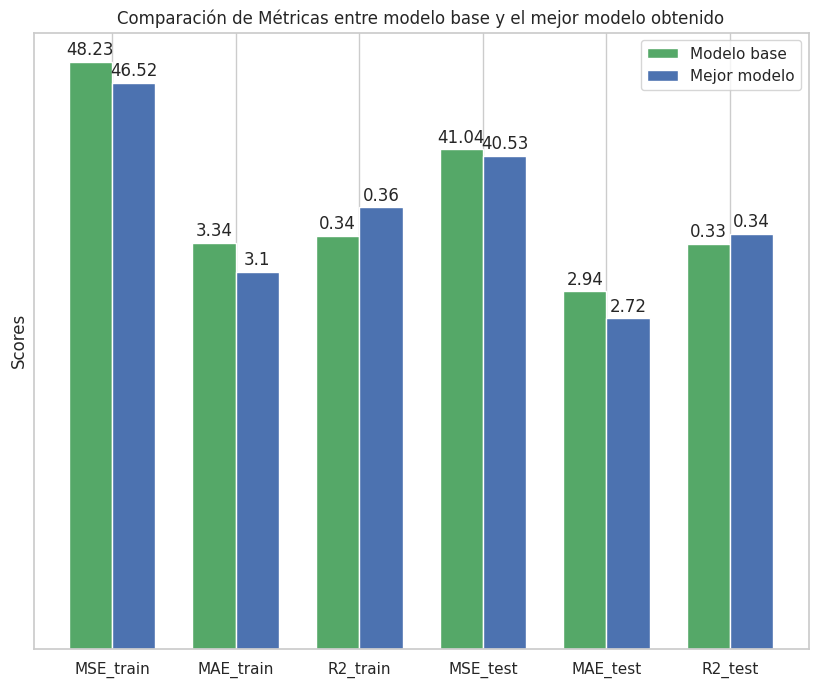

In [ ]:
def plot_metrics_comparison(data):
    metrics = data.columns
    regressor_model = data.iloc[0].values.flatten()
    best_regressor_model = data.iloc[1].values.flatten()
    width = 0.35  # Ancho de las barras

    for i in range(len(metrics)):
      if i in [1, 4]:
        regressor_model[i] = regressor_model[i] * 10
        best_regressor_model[i] = best_regressor_model[i] * 10
      elif i in [2, 5]:
        regressor_model[i] = regressor_model[i] * 100
        best_regressor_model[i] = best_regressor_model[i] * 100

    fig, ax = plt.subplots(figsize=(10, 8))

    # Barras para el modelo base
    test_bars = ax.bar(np.arange(len(metrics)) - width/2, regressor_model, width, label='Modelo base', color='g')

    # Barras para el mejor modelo
    train_bars = ax.bar(np.arange(len(metrics)) + width/2, best_regressor_model, width, label='Mejor modelo', color='b')


    # Desactivar las etiquetas del eje y
    ax.yaxis.set_major_locator(plt.NullLocator())

    # Eliminar las líneas de la cuadrícula del eje y
    ax.yaxis.grid(False)

    # Etiquetas, título y leyenda
    ax.set_ylabel('Scores')
    ax.set_title('Comparación de Métricas entre modelo base y el mejor modelo obtenido')
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_xticklabels(metrics)
    ax.legend()

    # Mostrar los valores en las barras
    def autolabel(bars):
        for i in range(len(bars)):
            bar = bars[i]
            height = bar.get_height()
            value = height
            if i in [1, 4]:
              value = height/10
            elif i in [2, 5]:
              value = height/100
            ax.annotate('{}'.format(round(value, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(train_bars)
    autolabel(test_bars)

    plt.show()

plot_metrics_comparison(pd.concat([nn_regressor_model_metrics_df, metrics_best_nn_regressor_model], ignore_index=True))

Se observa una clara mejoría entre ambos modelos.

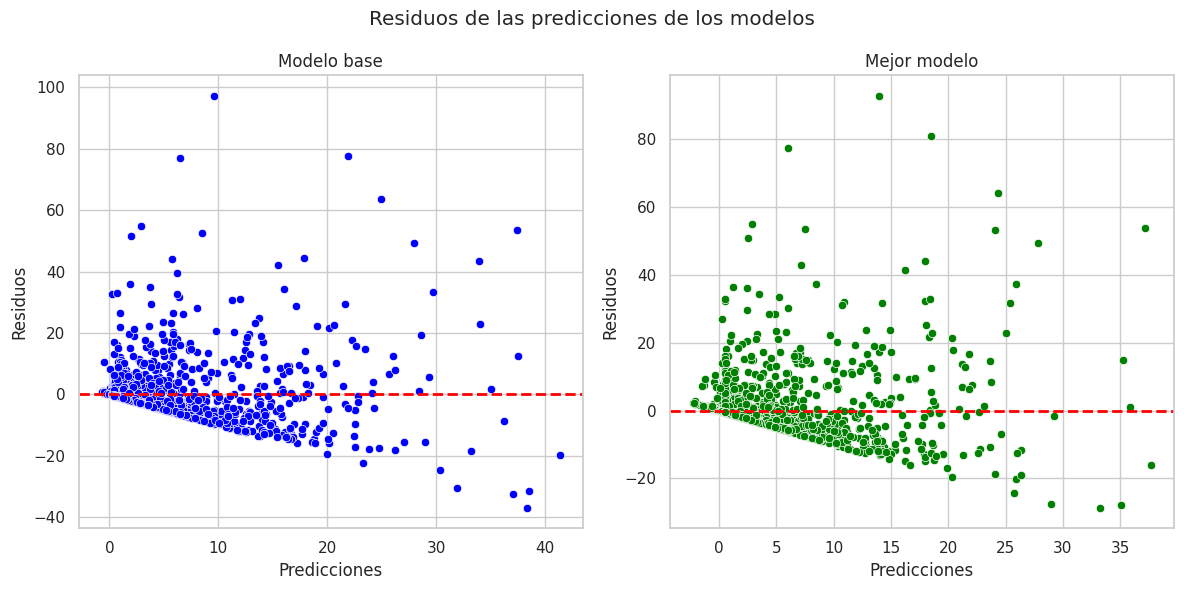

In [ ]:
def plot_residuals_side_by_side(base_model, best_model, x_test, y_true):
    # Obtener las predicciones de ambos modelos
    y_pred1 = [y_pred[0] for y_pred in base_model.predict(x_test, verbose=0)]
    y_pred2 = [y_pred[0] for y_pred in best_model.predict(x_test, verbose=0)]

    # Calcular los residuos para ambos modelos
    residuos1 = y_true.values - y_pred1
    residuos2 = y_true.values - y_pred2

    # Crear gráficos uno al lado del otro
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico para el primer modelo
    sns.scatterplot(x=y_pred1, y=residuos1, color='blue', ax=axs[0])
    axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axs[0].set_title('Modelo base')
    axs[0].set_xlabel('Predicciones')
    axs[0].set_ylabel('Residuos')

    # Gráfico para el segundo modelo
    sns.scatterplot(x=y_pred2, y=residuos2, color='green', ax=axs[1])
    axs[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axs[1].set_title('Mejor modelo')
    axs[1].set_xlabel('Predicciones')
    axs[1].set_ylabel('Residuos')

    fig.suptitle("Residuos de las predicciones de los modelos")

    # Ajustar el diseño para evitar superposición
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

plot_residuals_side_by_side(nn_regressor_model, best_nn_regressor_model, X_test_final, y_test_regressor_final)

Vemos como el mejor modelo predice con mayor eficacia dejando menos residuos.

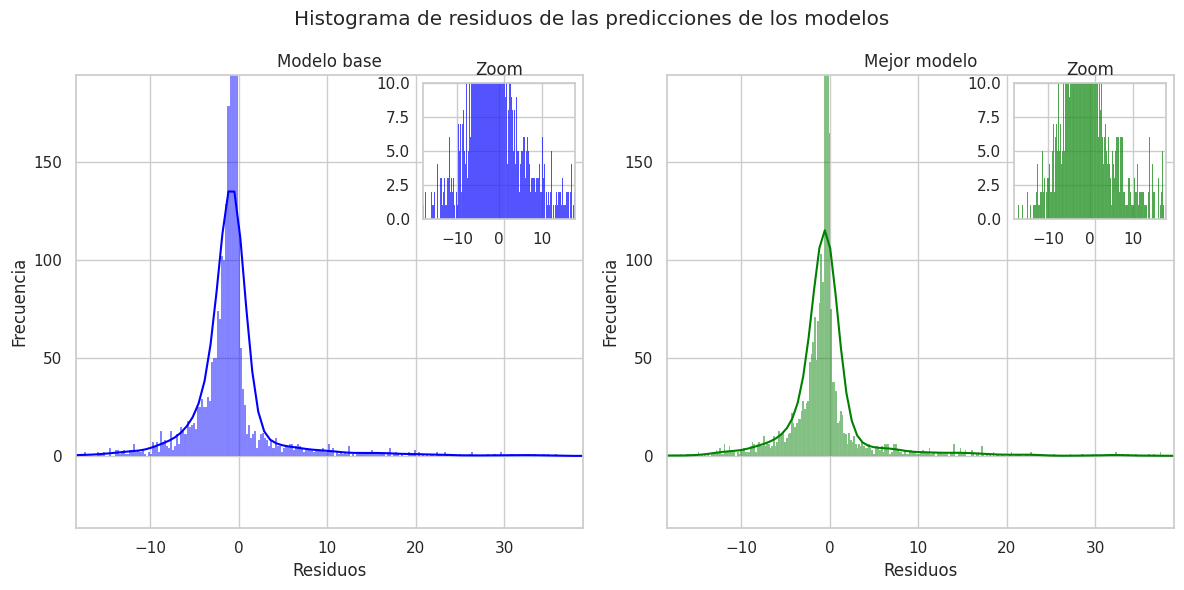

In [ ]:
def plot_residuals_histogram(base_model, best_model, x_test, y_true, zoom_xlim=None, zoom_ylim=None):
    # Obtener las predicciones de ambos modelos
    y_pred1 = [y_pred[0] for y_pred in base_model.predict(x_test, verbose=0)]
    y_pred2 = [y_pred[0] for y_pred in best_model.predict(x_test, verbose=0)]

    # Calcular los residuos para ambos modelos
    residuos1 = y_true.values - y_pred1
    residuos2 = y_true.values - y_pred2

    # Calcular el rango del eje y combinando ambos conjuntos de residuos
    combined_residuos = np.concatenate([residuos1, residuos2])
    y_min = combined_residuos.min()
    y_max = combined_residuos.max() * 2

    x_min = combined_residuos.min() / 2
    x_max = combined_residuos.max() / 2.5

    # Crear gráficos uno al lado del otro
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Histograma para el primer modelo
    sns.histplot(residuos1, kde=True, color='blue', ax=axs[0])
    axs[0].set_title('Modelo base')
    axs[0].set_xlabel('Residuos')
    axs[0].set_ylabel('Frecuencia')
    axs[0].set_ylim(y_min, y_max)
    axs[0].set_xlim(x_min, x_max)

    # Histograma para el segundo modelo
    sns.histplot(residuos2, kde=True, color='green', ax=axs[1])
    axs[1].set_title('Mejor modelo')
    axs[1].set_xlabel('Residuos')
    axs[1].set_ylabel('Frecuencia')
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xlim(x_min, x_max)

    fig.suptitle("Histograma de residuos de las predicciones de los modelos")

    # Ajustar el diseño para evitar superposición
    plt.tight_layout()

    if zoom_xlim is not None and zoom_ylim is not None:
      axins1 = inset_axes(axs[0], width="30%", height="30%", loc='upper right')
      sns.histplot(residuos1, color='blue', ax=axins1)
      axins1.set_ylabel('')
      axins1.set_xlim(zoom_xlim)
      axins1.set_ylim(zoom_ylim)
      axins1.set_title('Zoom')

      axins2 = inset_axes(axs[1], width="30%", height="30%", loc='upper right')
      sns.histplot(residuos2, color='green', ax=axins2)
      axins2.set_ylabel('')
      axins2.set_xlim(zoom_xlim)
      axins2.set_ylim(zoom_ylim)
      axins2.set_title('Zoom')


    # Mostrar los gráficos
    plt.show()

plot_residuals_histogram(nn_regressor_model, best_nn_regressor_model, X_test_final, y_test_regressor_final, (-18, 18), (0, 10))

Si bien, no se observa con mucha definición, vemos que los residuos de los valores tienden a ser menores cuando hacemos el cambio de modelo.

### Selección del mejor modelo de regresión

Se selecciona el mejor modelo obtenido para regresión, este modelo es el que se va a utilizar en nuestra aplicación para poder predecir la cantidad de lluvia que tendremos al día siguiente.

In [ ]:
best_nn_regressor_model.save_weights('best_nn_regressor_model.h5')
best_nn_regressor_model_json = best_nn_regressor_model.to_json()
with open('best_nn_regressor_model.json', "w") as json_file:
    json_file.write(best_nn_regressor_model_json)
json_file.close()

### Definición de modelo de clasificación base

A continuación definiremos un modelo de clasificación base basado en redes neuronales para poder tener métricas como parámetros para buscar mejores modelos.
Una vez definido lo entrenamos.

In [ ]:
def create_clasif_model(X, optimizer='adam', activation='relu', n_layers_hidden=1, neurons=[10]):
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation=activation))

    for i in range(n_layers_hidden):
        model.add(Dense(neurons[i], activation=activation))

    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


nn_clasif_model = create_clasif_model(X_train_final, n_layers_hidden=1, neurons=[2])
nn_clasif_model.fit(X_train_final, y_train_clasif_final, epochs=10, batch_size=32, validation_data=(X_test_final, y_test_clasif_final), verbose=0)

Lo testeamos y observamos sus métricas.

In [ ]:
def nn_clasif_model_metrics(model, X_train, X_test, y_train, y_test):
  y_pred_train = (model.predict(X_train, verbose=0) > 0.5).astype(int)
  y_pred_test = (model.predict(X_test, verbose=0) > 0.5).astype(int)

  accuracy_train = accuracy_score(y_train, y_pred_train)
  precision_train = precision_score(y_train, y_pred_train)
  recall_train = recall_score(y_train, y_pred_train)
  f1_train = f1_score(y_train, y_pred_train)
  auc_train = roc_auc_score(y_train, y_pred_train)

  accuracy_test = accuracy_score(y_test, y_pred_test)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  f1_test = f1_score(y_test, y_pred_test)
  auc_test = roc_auc_score(y_test, y_pred_test)

  metrics_dict = {
      'Accuracy_train': [accuracy_train],
      'Precision_train': [precision_train],
      'Recall_train': [recall_train],
      'F1_train': [f1_train],
      'AUC_train': [auc_train],
      'Accuracy_test': [accuracy_test],
      'Precision_test': [precision_test],
      'Recall_test': [recall_test],
      'F1_test': [f1_test],
      'AUC_test': [auc_test]
  }

  df_metrics = pd.DataFrame(metrics_dict)
  return df_metrics


nn_metrics_clasif_model = nn_clasif_model_metrics(nn_clasif_model, X_train_final, X_test_final, y_train_clasif_final, y_test_clasif_final)
nn_metrics_clasif_model

,Accuracy_train,Precision_train,Recall_train,F1_train,AUC_train,Accuracy_test,Precision_test,Recall_test,F1_test,AUC_test
0,0.803959,0.804569,0.555361,0.657131,0.743201,0.848684,0.716071,0.571225,0.635499,0.751609


Vemos buenas métricas aunque no mejores que los modelos realizados en la regresión logística, a continuación procederemos a realizar una búsqueda de los mejores parámetros para poder obtener el mejor modelo de clasificación.

### Prueba de hiperparámetros para modelo de redes neuronales de clasificación

Ahora procederemos a hacer una prueba de hiperparámetros para encontrar los óptimos.

Esta prueba se basa en encontrar al modelo que tenga el area bajo la curva de entrenamiento más alto.

In [ ]:
def hp_tuning_nn_clasif(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    n_units_layer = randint(8, 20)
    n_neurons = []

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', n_units_layer, n_units_layer) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        n_neurons.append(num_units)

    test_model = create_clasif_model(X_train_final, n_layers_hidden=num_layers, neurons=n_neurons)

    # entrenar
    test_model.fit(X_train_final, y_train_clasif_final, validation_data=(X_test_final, y_test_clasif_final), epochs=20, batch_size=32, verbose=0)

    score = nn_clasif_model_metrics(test_model, X_train_final, X_test_final, y_train_clasif_final, y_test_clasif_final)
    auc_train = score['AUC_train'].values[0]
    return auc_train

# crear un estudio de Optuna
study_clasif_nn = optuna.create_study(direction='maximize')
study_clasif_nn.optimize(hp_tuning_nn_clasif, n_trials=15)

best_params_nn_clasif = study_clasif_nn.best_params
print("Mejores parámetros encontrados:", best_params_nn_clasif)

Mejores parámetros encontrados: {'num_layers': 3, 'n_units_layer_0': 12, 'n_units_layer_1': 12, 'n_units_layer_2': 12}


Lo testeamos

In [ ]:
best_params_nn_model_clasif = {
    'n_layers_hidden': best_params_nn_clasif['num_layers'],
    'neurons': [best_params_nn_clasif[f'n_units_layer_{i}'] for i in range(best_params_nn_clasif['num_layers'])]
    }

best_nn_model_clasif = create_clasif_model(X_train_final, **best_params_nn_model_clasif)
best_nn_model_clasif.fit(X_train_final, y_train_clasif_final, epochs=20, verbose=0)

metrics_nn_best_model_clasif = nn_clasif_model_metrics(best_nn_model_clasif, X_train_final, X_test_final, y_train_clasif_final, y_test_clasif_final)
metrics_nn_best_model_clasif

,Accuracy_train,Precision_train,Recall_train,F1_train,AUC_train,Accuracy_test,Precision_test,Recall_test,F1_test,AUC_test
0,0.813678,0.773932,0.634548,0.697343,0.769898,0.840132,0.658824,0.638177,0.648336,0.769473


Y vemos una leve mejoría en los valores, a continuación visualizaremos sus resultados en gráficos para una mejor comparación.

### Visualización del desempeño del modelo de clasificación

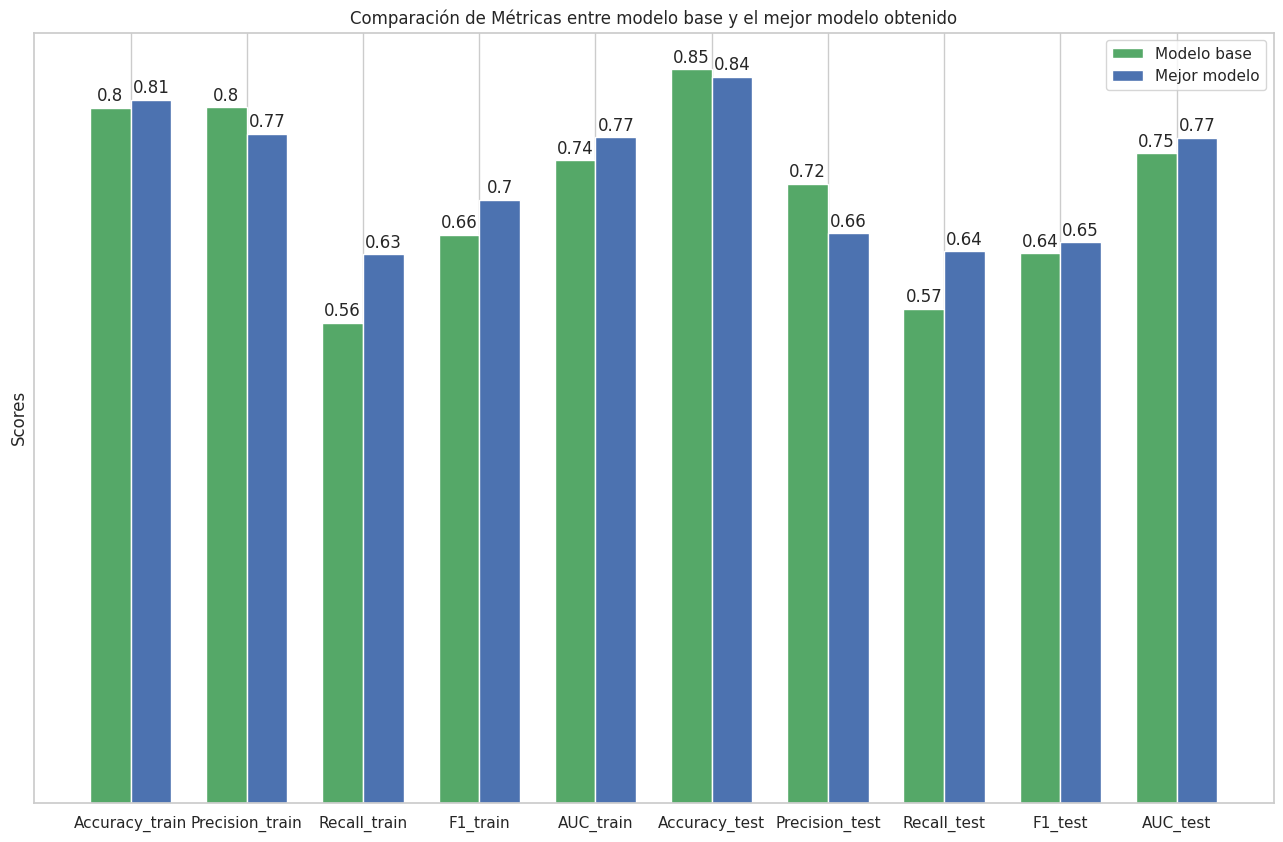

In [ ]:
def plot_clasif_metrics_comparison(data):
    metrics = data.columns
    regressor_model = data.iloc[0].values.flatten()
    best_regressor_model = data.iloc[1].values.flatten()
    width = 0.35  # Ancho de las barras

    fig, ax = plt.subplots(figsize=(16, 10))

    # Barras para el modelo base
    base_model_bars = ax.bar(np.arange(len(metrics)) - width/2, regressor_model, width, label='Modelo base', color='g')

    # Barras para el mejor modelo
    best_model_bars = ax.bar(np.arange(len(metrics)) + width/2, best_regressor_model, width, label='Mejor modelo', color='b')


    # Desactivar las etiquetas del eje y
    ax.yaxis.set_major_locator(plt.NullLocator())

    # Eliminar las líneas de la cuadrícula del eje y
    ax.yaxis.grid(False)

    # Etiquetas, título y leyenda
    ax.set_ylabel('Scores')
    ax.set_title('Comparación de Métricas entre modelo base y el mejor modelo obtenido')
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_xticklabels(metrics)
    ax.legend()

    # Mostrar los valores en las barras
    def autolabel(bars):
        for i in range(len(bars)):
            bar = bars[i]
            height = bar.get_height()
            value = height
            ax.annotate('{}'.format(round(value, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(best_model_bars)
    autolabel(base_model_bars)

    plt.show()

plot_clasif_metrics_comparison(pd.concat([nn_metrics_clasif_model, metrics_nn_best_model_clasif], ignore_index=True))

Vemos que si bien el modelo con hp tuning no mejoró tanto aún así da mejores métricas que el anterior por lo que nos podemos apoyar en ese de ahora en más.

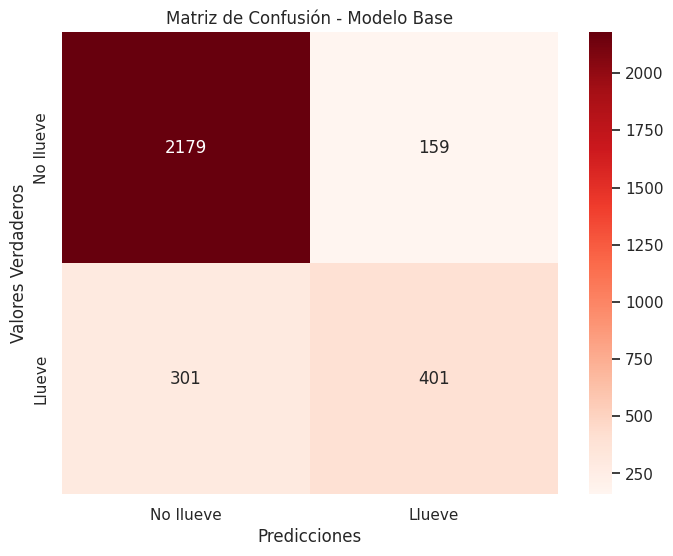

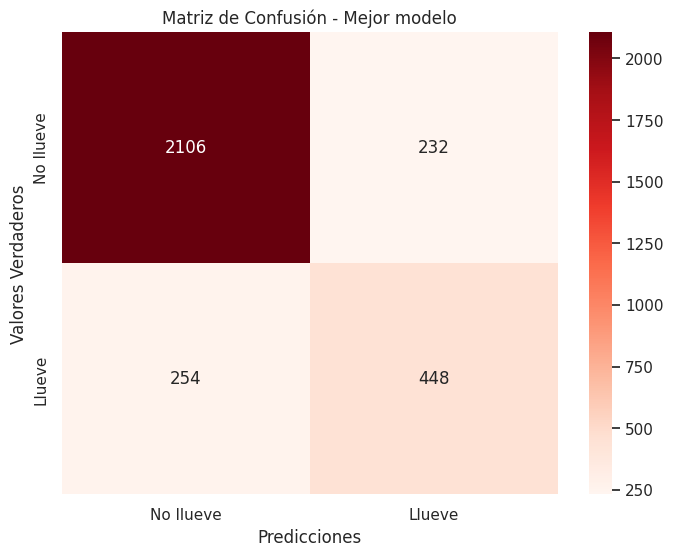

In [ ]:
def plot_conf_matrix(model, X_test, y_test, modelo_str):
  y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
  conf_matrix = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No llueve', 'Llueve'], yticklabels=['No llueve', 'Llueve'])
  plt.title(f'Matriz de Confusión - {modelo_str}')
  plt.xlabel('Predicciones')
  plt.ylabel('Valores Verdaderos')
  plt.show()


plot_conf_matrix(nn_clasif_model, X_test_final, y_test_clasif_final, 'Modelo Base')
plot_conf_matrix(best_nn_model_clasif, X_test_final, y_test_clasif_final, 'Mejor modelo')

Inclusive predice con mayor precisión los días que llueve.

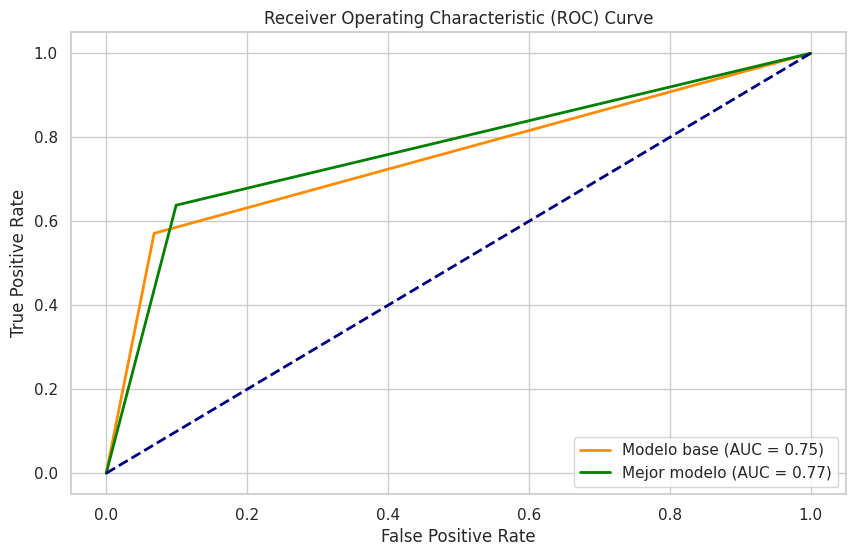

In [ ]:
def plot_roc_curve(model1, model2, X_test, y_test, model1_label='Model 1', model2_label='Model 2'):
    # Predicciones de los modelos
    predictions_model1 = (model1.predict(X_test, verbose=0) > 0.5).astype(int)
    predictions_model2 = (model2.predict(X_test, verbose=0) > 0.5).astype(int)

    # Curva ROC para el modelo 1
    fpr_model1, tpr_model1, _ = roc_curve(y_test, predictions_model1)
    roc_auc_model1 = auc(fpr_model1, tpr_model1)

    # Curva ROC para el modelo 2
    fpr_model2, tpr_model2, _ = roc_curve(y_test, predictions_model2)
    roc_auc_model2 = auc(fpr_model2, tpr_model2)

    # Graficar las curvas ROC
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label=f'{model1_label} (AUC = {roc_auc_model1:.2f})')
    plt.plot(fpr_model2, tpr_model2, color='green', lw=2, label=f'{model2_label} (AUC = {roc_auc_model2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Uso de la función
plot_roc_curve(nn_clasif_model, best_nn_model_clasif, X_test_final, y_test_clasif_final, model1_label='Modelo base', model2_label='Mejor modelo')

Si bien como vimos anteriormente, el modelo no mejora mucho, presenta una mejoría diferenciando entre las clases lo que lo hace utilizable para este tipo de predicciones.

# **Conclusiones**

### *Regresión lineal*

Las metricas de los modelos en general no se podria considerar muy buenas, ya que un R2 de 0.27 representa una baja explicabilidad de los datos para el modelo. Y los graficos de residuos y predicciones no son muy buenos.

Aun asi, este es el mayor puntaje obtenido, por lo que tenemos preferencia sobre el modelo de regresion lineal para realizar predicciones de la cantidad de lluvia para este conjunto de datos en particular, para esta consigna en particular.

Si bien el redimiento de las predicciones podria mejorarse a traves de modelos no lineales mas complejos o con modelos de enfoque conexionista, por el momento, nos limitamos a la predicciones como modelos de regresion lineal.

---



#### *Regresión Logistica*

El modelo de clasificacion de regresion logistica ha demostrado un buen rendimiento para realizar estimaciones con nuevos datos sobre la presencia de lluvia. Se ha probado mediante hiperparametrizacion que se pueden conseguir configuraciones en el modelo que optimizan las metricas de validacion.

Y de hecho, este modelo de regresion logistica ha logrado un mejor rendimiento que el modelo de clasificacion con redes neuronales encontrando un modelo mas apto y balanceado para futuras estimaciones.

Ademas este modelo resulta ser muy explicativo debido a que los valores de shap son muy altos para algunas de las variables, pudiento interpretar variables meterologicas signitifativas para las predicciones.

---



#### *Redes Neuronales*

En el primer desarrollo se buscó crear una red neuronal compuesta por variables de entradas y 1 salida la cual correspondía a una regresión lineal, según las métricas se observó que el desarrollo de la misma era superior a la realizada en la entrega 1 pero aún así sus métricas eran malas por lo que por términos de rendimiento este modelo no sería lo óptimo para su utilización.

En el segundo desarrollo se buscó crear una red neuronal categorica apoyandonos en una regresión logística teniendo en cuenta 2 clases que podía tomar la variable objetivo siendo esta verdadero o falso (verdadero si llueve y falso si no llueve), luego de procesar este modelo se vió que las métricas daban muy buen resultado por lo que este tipo de modelos son aptos para su utilización y posterior implementación ya que este tipo de modelos es bueno encontrando patrones dentro de los atributos.

En ambos desarrollos se hicieron pruebas de hiperparámetros para buscar la combinación de parámetros que ayude al modelo a dar mejores resultados, estos solamente variaban la cantidad de capas ocultas y neuronas que contenía nuestro modelo pero, aún así, resultaron completamente efectivo ya que (por más leve que sea) ayudaron a mejorar las métricas de nuestro modelo.

---


#### *Conlusción General*

Como conclusión final se optó por utilizar como modelo de regresión el realizado en el análisist de redes neuronales, si bien este modelo no es óptimo para su uso, es el mejor encontrado para este contexto.

Como modelo de clasificación se vieron buenas métricas en todos los sentidos y el que más precisión mantuvo antes estos casos fue el modelo de clasificación, dandonós así un modelo óptimo para su uso en estos casos.